# Amazon reviews

> To get a better notebook formatting, [click here](https://nbviewer.jupyter.org/github/Coac/epfl-ada/blob/master/Project/Project.ipynb).

> Check out the data story [here](https://adamazon.github.io/).

> Please also check the [readme](https://github.com/Coac/epfl-ada/blob/master/Project/README.md) containing additional explanations.

This notebook contains an exploratory analysis of one specific category of products of the Amazon reviews. Our objective is to be able to understand how reviews are distributed and find some useful insights to provide a deeper analysis to answer our research questions.

## Summary

1. [Data importation](#Data-importation)
2. [Descriptive analysis](#Descriptive-analysis)
3. [Correlations](#Correlations)
4. [Words occurences](#Words-occurences)
5. [Machine learning exploratory](#Machine-learning-exploratory)
6. [Deeper analysis](#Deeper-analysis)

   a. [Regression model](#Regression-model)  
   b. [Classification](#Classification)    
   
7. [Conclusion](#Conclusion)

In [309]:
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
from matplotlib import pyplot as plt
import math as math

import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_context("poster")
from operator import itemgetter

from functions.py import * 
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.base import BaseEstimator, TransformerMixin

## Data importation

We first start by importing data. Because we focus on one specific category (*video games*), we won't need to use Spark here.

### Download the data

We will use the 5-core reviews which can be downloaded here: http://jmcauley.ucsd.edu/data/amazon/links.html. The exact file used for video games import is http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz.

### File preparation

After downloading the file, we turn it to a valid, json array to ease importation. We use the following sed commands to do so:

```sh
sed -i '1s/^/[/' data/file.json # Starts JSON array
sed -i 's/$/,/' data/file.json # Separate objects with commas
sed -i '$ s/,$/]/g' data/file.json # Ends JSON array
```

### Pandas importation

#### Load products reviews


We import data and start by doing some simple cleaning. Dates are stored in two different formats (`reviewTime` and `unixReviewTime`). We will use the latest one to create a new `date` field with standard DateTime format, which will be easier to handle.

We create a two-level index to allow grouping reviews per product and reviewer.

In [2]:
video_games = pd.read_json('./data/video-games.json')

# Cleaning dates
del video_games['reviewTime'] # Duplicated information (already in unix review time)
video_games['date'] = pd.to_datetime(video_games['unixReviewTime'], unit='s')
del video_games['unixReviewTime']

video_games.set_index(['asin', 'reviewerID'], inplace=True)

assert video_games.index.is_unique, 'There should be no more than one review per person per product'

video_games.dtypes

helpful                 object
overall                  int64
reviewText              object
reviewerName            object
summary                 object
date            datetime64[ns]
dtype: object

We can see data types are already guessed by Pandas. We need, however, to reformat the `helpful` field. It is currently stored as an array of two values, the first one describing how many users voted the review was helpful and the second one describing how many votes the review received.

### Data formatting

To ease data handling, we will calculate the `helpfulRate` of each comment. It will help us extracting which reviewers are providing the best reviews on one or multiple products. When a review does not have any helpful votes, the rate will be set to `-1`.

We also store the number of total reviews in a new row so we can take rid of the helpful array.

In [3]:
def helpful_rate(row):
    '''
    Calculates the helpful rate of a review by determining what
    percentage of the votes described the review as "helpful".
    '''
    was_helpful = row.helpful[0]
    total_evaluations = row.helpful[1]
    
    if total_evaluations == 0:
        return -1
    
    return was_helpful/total_evaluations

def helpful_count(row):
    '''
    Gets the total number of helpful votes for a review
    '''
    return row.helpful[1]

video_games['helpfulRate'] = video_games.apply(helpful_rate, axis=1)
video_games['helpfulCount'] = video_games.apply(helpful_count, axis=1)
del video_games['helpful']

assert len(video_games[video_games['helpfulCount'] == 0]) == len(video_games[video_games['helpfulRate'] == -1])

video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A3UR8NLLY1ZHCX        4   
           A1INA0F5CWW3J4        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  helpfulCount  
asin       reviewerID                                            
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000             0  
           A1INA0F5CWW3J4 2014-06-28    -1.000000             0  
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  
           A361M14PU2GUEG 2011-06-14     1.000000             2

Here is a first view of the data. All the reviews are grouped by product described by its product ID (`asin`). Then, for each product, all the reviews are indexed by the reviewer.

Each column of the dataframe is self-descriptive (notice that `overall` is the grade given from the reviewer in a scale between 1 and 5) and data types are allowing us to perform our analysis.

#### Load products reviews

We now load *video games* metadata. The exact file used here is: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Video_Games.json.gz. We had some trouble importing the file, so we had to make some transformations in addition to the `sed` ones, because strings were surrounded by simple quotes instead of double quotes. Here is the Python script we used:

```python
import ast
import json

with open('./data/video-games.meta.json', 'r') as metadata:
    raw_data = metadata.read().replace('\n', '')
    parsed_data = ast.literal_eval(raw_data)

with open('./data/video-games.meta.parsed.json', 'w') as parsed:
    json.dump(parsed_data, parsed)
```

In [4]:
video_games_meta = pd.read_json('./data/video-games.meta.parsed.json')

del video_games_meta['imUrl']
del video_games_meta['related'] # For now we remove related (also bought, also viewed and buy after viewing) products
del video_games_meta['categories'] # We get rid of the sub categories for now

video_games_meta.price.fillna(-1, inplace=True)
video_games_meta.title.fillna('', inplace=True)
video_games_meta.brand.fillna('', inplace=True)
video_games_meta.description.fillna('', inplace=True)

# The following line can be understood as:
# video_games_meta.salesRank.fillna({}, inplace=True)
# It is done using this process because Pandas won't take into account the empty {} with fillna()
video_games_meta.loc[video_games_meta['salesRank'].isnull(), ['salesRank']] = video_games_meta.loc[video_games_meta['salesRank'].isnull(), 'salesRank'].apply(lambda x: {})

video_games_meta.set_index(['asin'], inplace=True)

video_games_meta.head()

,brand,description,price,salesRank,title
asin,,,,,
0078764343,,Brand new sealed!,37.98,{'Video Games': 28655},
043933702X,,In Stock NOW. Eligible for FREE Super Saving ...,23.50,{'Video Games': 44080},
0439339987,,Grandma Groupers kelp seeds are missing and wi...,8.95,{'Video Games': 49836},
0439342260,,This software is BRAND NEW. Packaging may diff...,-1.00,{'Video Games': 49156},
0439339960,,a scholastic clubs fairs cd rom game,-1.00,{'Video Games': 52262},


We need to get rid of the nested objects and arrays. We will take into account only the `salesRank` for video games section.

In [5]:
def sales_rank(row):
    '''
    Returns the video games sales rank from the sub object
    '''

    if not 'Video Games' in row.salesRank.keys():
        return -1
    
    return row.salesRank['Video Games']
    
video_games_meta['rank'] = video_games_meta.apply(sales_rank, axis=1)
del video_games_meta['salesRank']

video_games_meta.head()

,brand,description,price,title,rank
asin,,,,,
0078764343,,Brand new sealed!,37.98,,28655
043933702X,,In Stock NOW. Eligible for FREE Super Saving ...,23.50,,44080
0439339987,,Grandma Groupers kelp seeds are missing and wi...,8.95,,49836
0439342260,,This software is BRAND NEW. Packaging may diff...,-1.00,,49156
0439339960,,a scholastic clubs fairs cd rom game,-1.00,,52262


Things are now clean in off to merge the two dataframes. We will allow to have duplicate `brand`, `description`, `price`, `title` and `rank` for each review as it will help finding correlations.

In [6]:
# We concatenate our dataframes based on the product ID index
video_games_ids = video_games.index.get_level_values('asin')

video_games['rank'] = video_games_meta.loc[video_games_ids]['rank'].values
video_games['description'] = video_games_meta.loc[video_games_ids]['description'].values
video_games['price'] = video_games_meta.loc[video_games_ids]['price'].values
video_games['title'] = video_games_meta.loc[video_games_ids]['title'].values
video_games['brand'] = video_games_meta.loc[video_games_ids]['brand'].values

video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A3UR8NLLY1ZHCX        4   
           A1INA0F5CWW3J4        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  helpfulCount  rank  \
asin       reviewerID                                                   
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  6629   
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000             0  6629   
           A1INA0F5CWW3J4 2014-06-28    -1.000000             0  6629   
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  6629   
           A361M14PU2GUEG 2011-06-14     1.000000             2  6629   

                                                                 description  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Dirt 3 is a popular rally racing game for Play...   
           A3UR8NLLY1ZHCX  Dirt 3 is a popular rally racing game for Play...   
           A1INA0F5CWW3J4  Dirt 3 is a popular rally racing game for Play...   
           A1DLMTOTHQ4AST  Dirt 3 is a popular rally racing game for Play...   
           A361M14PU2GUEG  Dirt 3 is a popular rally racing game for Play...   

                            price title brand  
asin       reviewerID                          
0700099867 A2HD75EMZR8QLN  246.63              
           A3UR8NLLY1ZHCX  246.63              
           A1INA0F5CWW3J4  246.63              
           A1DLMTOTHQ4AST  246.63              
           A361M14PU2GUEG  246.63

### Missing values
We check if our data frame contains missing data

In [7]:
null_data = video_games[video_games.isnull().any(axis=1)]
print("There are", len(null_data), "rows containing missing values")

print("Columns with missing datas:", list(video_games.columns[video_games.isnull().any()]))

null_data.head()

There are 2813 rows containing missing values
Columns with missing datas: ['reviewerName']


overall  \
asin       reviewerID                
9861019731 A26HSO6VAFB2V4        5   
B00000F1GM A2WTO0ST2SUUY9        5   
B00000I1BF A3OU09O34BC73         5   
           ANLC4FX4QK23V         5   
B00000IWYT A1OYBF92TASIWN        5   

                                                                  reviewText  \
asin       reviewerID                                                          
9861019731 A26HSO6VAFB2V4      It works perfectly! Nothing is wrong with it.   
B00000F1GM A2WTO0ST2SUUY9  For those of you who haven't played Super Mari...   
B00000I1BF A3OU09O34BC73   classic game for the ps1. i love it and it sti...   
           ANLC4FX4QK23V   I was feeling nostalgic so I bought this game ...   
B00000IWYT A1OYBF92TASIWN  Wow...the only Game Boy games that even come c...   

                          reviewerName                              summary  \
asin       reviewerID                                                         
9861019731 A26HSO6VAFB2V4          NaN                             Perfect!   
B00000F1GM A2WTO0ST2SUUY9          NaN                Super Mario 64 Review   
B00000I1BF A3OU09O34BC73           NaN                             so fun!!   
           ANLC4FX4QK23V           NaN                 Blast from the past!   
B00000IWYT A1OYBF92TASIWN          NaN  By far, the best Game Boy game ever   

                                date  helpfulRate  helpfulCount  rank  \
asin       reviewerID                                                   
9861019731 A26HSO6VAFB2V4 2014-07-13         -1.0             0   579   
B00000F1GM A2WTO0ST2SUUY9 2013-01-10          1.0             3   699   
B00000I1BF A3OU09O34BC73  2014-07-13         -1.0             0  2059   
           ANLC4FX4QK23V  2013-06-17         -1.0             0  2059   
B00000IWYT A1OYBF92TASIWN 2001-04-16         -1.0             0  4422   

                                                                 description  \
asin       reviewerID                                                          
9861019731 A26HSO6VAFB2V4  Compatible with:\nNINTENDO Wii & Gamecube\nPac...   
B00000F1GM A2WTO0ST2SUUY9  The game that launched the Nintendo 64 system ...   
B00000I1BF A3OU09O34BC73   Spyro is a cute purple dragon in a bit of a pi...   
           ANLC4FX4QK23V   Spyro is a cute purple dragon in a bit of a pi...   
B00000IWYT A1OYBF92TASIWN  The legendary Link of Hirule tackles a new que...   

                            price  \
asin       reviewerID               
9861019731 A26HSO6VAFB2V4    4.42   
B00000F1GM A2WTO0ST2SUUY9  299.99   
B00000I1BF A3OU09O34BC73    90.00   
           ANLC4FX4QK23V    90.00   
B00000IWYT A1OYBF92TASIWN  186.74   

                                                                       title  \
asin       reviewerID                                                          
9861019731 A26HSO6VAFB2V4  64MB 1019 Block Memory Card compatible for Wii...   
B00000F1GM A2WTO0ST2SUUY9                                                      
B00000I1BF A3OU09O34BC73                                                       
           ANLC4FX4QK23V                                                       
B00000IWYT A1OYBF92TASIWN                                                      

                             brand  
asin       reviewerID               
9861019731 A26HSO6VAFB2V4  Generic  
B00000F1GM A2WTO0ST2SUUY9           
B00000I1BF A3OU09O34BC73            
           ANLC4FX4QK23V            
B00000IWYT A1OYBF92TASIWN

Our dataframe contains missing values. However, it's only true for two columns : `reviewerName` and `reviewerNameLength`. These informations are not crucial for our analysis, so we can ignore this.

## Descriptive analysis

Our descriptive analysis will focus on several metrics taken from the above dataframe. We will first focus on the distribution of reviews grade (`overall`) and then analyse "helpful evaluations" of reviews. Finally, we will start searching for patterns in data distribution to prepare work for the next milestone.

### Distribution of possible review grades

We start by using a box plot to visualize how grades are distributed.

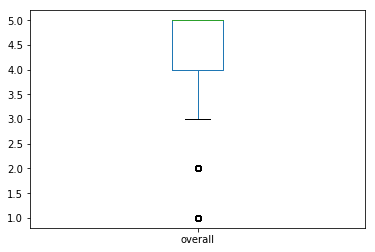

In [8]:
video_games.boxplot(column=['overall'], figsize=(8, 8), grid=False)

We can see that there is definitely more high grades (4, 5) than low ones. Let's describe data to get some insights.

In [9]:
video_games.overall.describe()

count    231780.000000
mean          4.086397
std           1.202330
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

We have 231780 reviews, with a mean of 4.08 and a standard deviation of 1.20.

When focusing at **robust statistics** only, we can see that the median is 5, and more than 75% of the reviews have awarded 4 or 5 grade to the product.

Let's see data distribution using a bar plot:

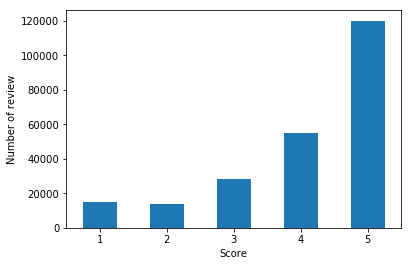

In [10]:
plt.xlabel('Score')
plt.ylabel('Number of review')
video_games.overall.value_counts(ascending=True).sort_index().plot(kind='bar', rot=0)

This confirms what was found before. We can do some assumptions about this distribution:

- The people may be more likely to thank the product quality by posting a review than to say their displeasure
- Amazon sell more good quality product (here video game) than bad one
- The 5 stars review can be due to the presence of fakes/paid review

We also can see that there are more reviews with `1` grade than `2`. This could be understood as people underrating products when they are not fully satisfied. It may also be used by customers to counterbalance a too high grade on a product, based on their opinions.

We now count the number of reviews per product to see if products are equally reviewed:

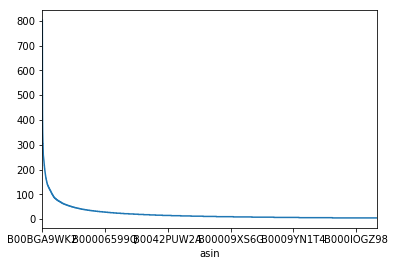

In [11]:
reviews_count_per_product = video_games.groupby(['asin']).overall.count().sort_values(ascending=False)

reviews_count_per_product.plot()

We seem to have a power law. However when using a logarithmic plot, we can see it is not:

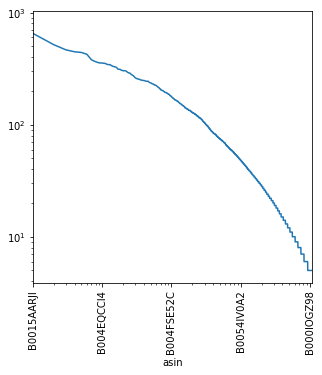

In [12]:
warnings.simplefilter('ignore') # Ignoring warning about non positive xlimit

reviews_count_per_product.plot(logy=True, logx=True, rot=90, figsize=(5, 5))

Let's see if users tend to review products when they are pricy:

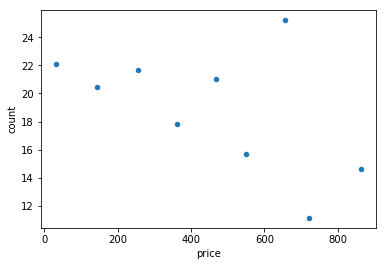

In [13]:
nb_reviews_per_product = pd.DataFrame()

# We count the number of reviews per product
nb_reviews_per_product['count'] = video_games[video_games.price > 0].groupby('asin').overall.count()
# We also add the product price
nb_reviews_per_product['price'] = video_games[video_games.price > 0].groupby('asin').price.mean()

# We create price beans because we have more products in specific price ranges
bins = range(0, 1000, 100)
nb_reviews_per_product['price_group'] = pd.cut(nb_reviews_per_product['price'], bins, labels=range(1, 10))#.plot(kind='scatter', x='price', y='count')

nb_reviews_per_product.groupby(['price_group']).mean().plot(kind='scatter', x='price', y='count')

We can't conclude much here. We can see a spike around 600$ which is due to existing game consoles at this price range, which are clearly more popular.

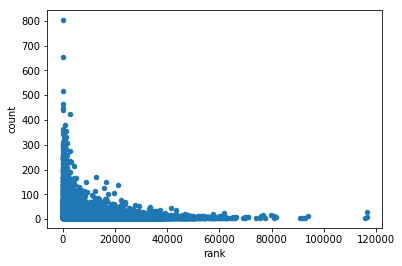

In [14]:
nb_reviews_per_product = pd.DataFrame()

nb_reviews_per_product['count'] = video_games.groupby('asin').overall.count()
nb_reviews_per_product['rank'] = video_games.groupby('asin').rank.mean()

nb_reviews_per_product.plot(kind='scatter', x='rank', y='count')

In [15]:
# We use spearman correlation here because we definitely
# can't have a linear relation between the two based on above graph
nb_reviews_per_product.corr(method='spearman') 

,count,rank
count,1.000000,-0.443484
rank,-0.443484,1.000000


Results seems logical, if a product is well-ranked, it is most likely because it has a lot of reviews, and has actually being purchased. The correlation is however weak as it only concerns the maximum number of reviews. We can still find high ranked products with few reviews.

Let's focus on the most reviewed product. The product is the "PlayStation 4 500GB Console". Notice that the price is not logical. After verification, there was no issue with the data importation. We will have to proceed with caution when using it as a feature.

In [16]:
most_reviewed = reviews_count_per_product.index[0]
most_reviewed_reviews = video_games.loc[most_reviewed]

most_reviewed_reviews.head()

,overall,reviewText,reviewerName,summary,date,helpfulRate,helpfulCount,rank,description,price,title,brand
reviewerID,,,,,,,,,,,,
A386ZNRX0TFFHX,4,I gave it 4 out of 5 stars because of lack of ...,NaN,"Great System, But...",2013-12-18,0.727273,11,13,,28.12,,
A2QYAFX7OCNRMO,3,PlayStation 4 is kind of hard to review right ...,NaN,Has potential...,2014-03-05,0.727273,11,13,,28.12,,
A3OQ3DU03L2GGO,5,Simply amazing. A huge step up from the PS3 an...,NaN,Stunning.,2013-12-01,0.727273,11,13,,28.12,,
A3H99DFEG68SR,3,So I've had the PS4 since launch and I have to...,1m2,I guess I expected more,2014-03-21,-1.000000,0,13,,28.12,,
A15LG7HS4WKKKS,5,Huge overall improvement over the PS3. The use...,"A. A. BADER ""Q8 AL BADER""","Best purchase all year.,",2014-03-06,0.700000,10,13,,28.12,,


We try to see if there are any trends in the reviews over time:

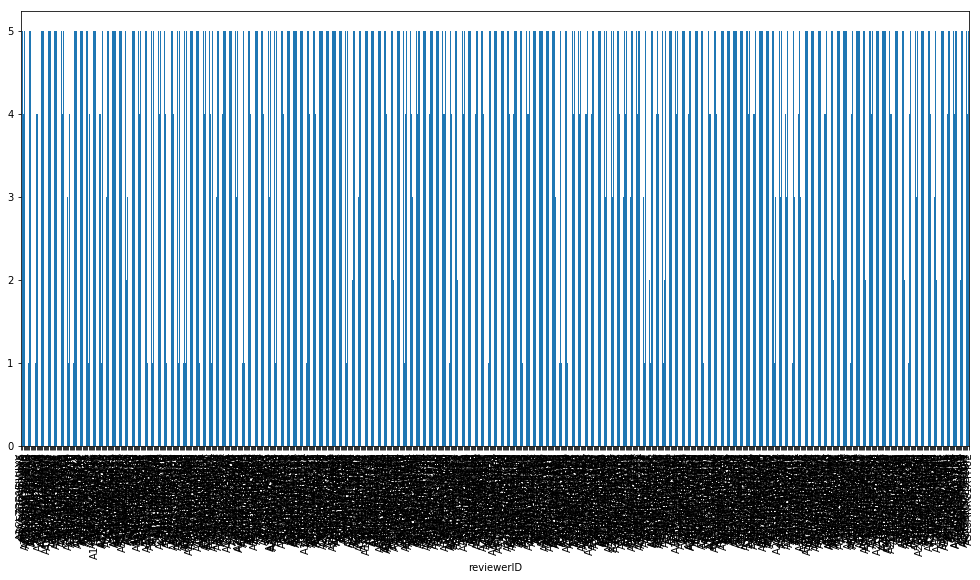

In [17]:
most_reviewed_reviews.sort_values(by=['date'], inplace=True)
most_reviewed_reviews.overall.plot(kind='bar', figsize=(17, 8), rot=90);

It is impossible to visually see any kind of trend. However, it may be possible using machine learning to determine if some grades can be deducted from the previous ones.

### Distribution of helpful rates

We do the same analysis for the helpful rate (after removing the reviews without evaluation):

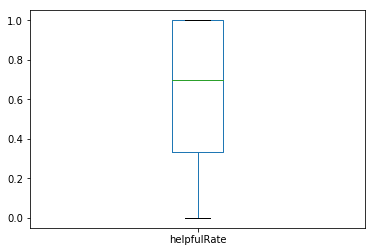

In [18]:
video_games[video_games.helpfulRate >= 0].boxplot(column=['helpfulRate'], figsize=(8, 8), grid=False);

Here, we can see rates are more widely distributed, let's do the same description as before.

In [19]:
video_games[video_games.helpfulRate >= 0].helpfulRate.describe()

count    139855.000000
mean          0.622347
std           0.369065
min           0.000000
25%           0.333333
50%           0.695652
75%           1.000000
max           1.000000
Name: helpfulRate, dtype: float64

Distribution seems more balanced, since first quartile is 0.33, median is 0.69 and last quartile is 0.75. We may however do the assumption that helpful reviews are more likely to be evaluated as even more helpful as Amazon will display those reviews first.

We now look at the distribution of helpful rates, considering all the sold products.

60.34% of reviews are evaluated


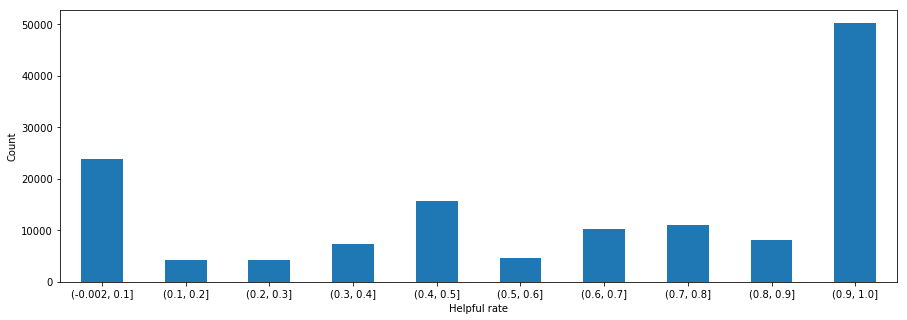

In [20]:
# We get all the "helpfulness rates" (removing the unrated comments)
helpfulRates = video_games[video_games.helpfulRate >= 0].helpfulRate

print(str(round(len(helpfulRates) * 100 / len(video_games.helpfulRate), 2)) + '% of reviews are evaluated')

plt.xlabel('Helpful rate')
plt.ylabel('Count')
helpfulRates.value_counts(ascending=True, bins=10).sort_index().plot(kind='bar', rot=0, figsize=(15, 5));

We can see two outsiders for reviews with less than 10% positive reviews and more than 90% positive reviews. This could be explained by the assumption made previously: the more a review is well rated, the more it is likely to get good rates. In the contrary, reviews with bad rates may be less visible on Amazon and may keep their low rates.

We will now sort the reviewers based on their helpful rate mean, to see if there are some top reviewers or very bad ones.

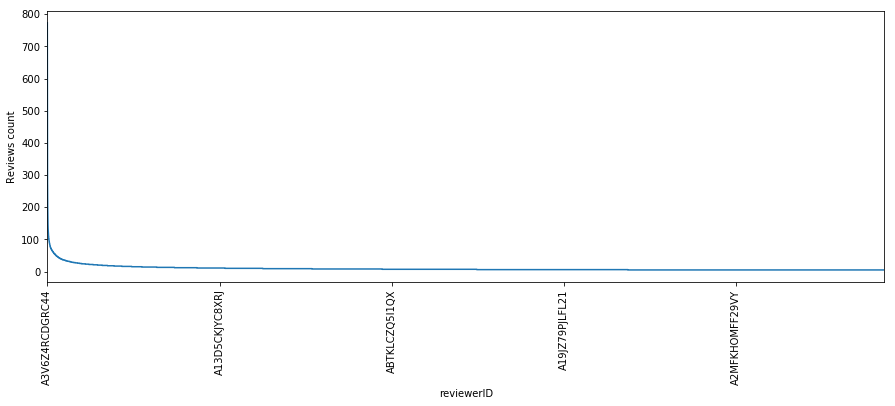

In [21]:
count_evaluations = video_games.groupby('reviewerID').overall.count().sort_values(ascending=False)

plt.ylabel('Reviews count')
count_evaluations.plot(rot=90, figsize=(15, 5));

In [22]:
count_evaluations.describe()

count    24303.000000
mean         9.537094
std         12.789697
min          5.000000
25%          5.000000
50%          7.000000
75%         10.000000
max        773.000000
Name: overall, dtype: float64

We try to zoom to get only evaluators with more than 30 evaluations. We can see that evaluations are done by a restricted number of evaluators providing the majority of evaluations.

1st best evaluator: 773
2nd best evaluator: 635
3rd best evaluator: 456
4th best evaluator: 450
5th best evaluator: 404
6th best evaluator: 320
7th best evaluator: 272
8th best evaluator: 268
9th best evaluator: 224
10th best evaluator: 220


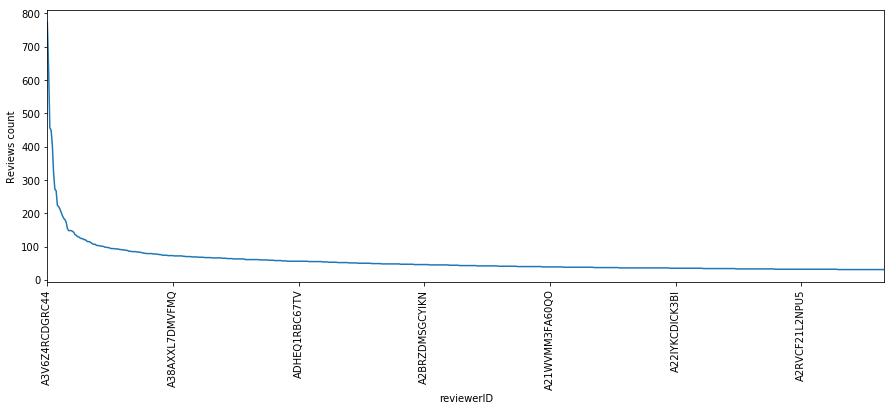

In [23]:
top_count_evaluations = count_evaluations[count_evaluations > 30]
plt.ylabel('Reviews count')
top_count_evaluations.plot(rot=90, figsize=(15, 5))

print('1st best evaluator: ' + str(top_count_evaluations[0]))
print('2nd best evaluator: ' + str(top_count_evaluations[1]))
print('3rd best evaluator: ' + str(top_count_evaluations[2]))
print('4th best evaluator: ' + str(top_count_evaluations[3]))
print('5th best evaluator: ' + str(top_count_evaluations[4]))
print('6th best evaluator: ' + str(top_count_evaluations[5]))
print('7th best evaluator: ' + str(top_count_evaluations[6]))
print('8th best evaluator: ' + str(top_count_evaluations[7]))
print('9th best evaluator: ' + str(top_count_evaluations[8]))
print('10th best evaluator: ' + str(top_count_evaluations[9]))

We seem to have a power law here. We try to confirm this using a logarithmic plot:

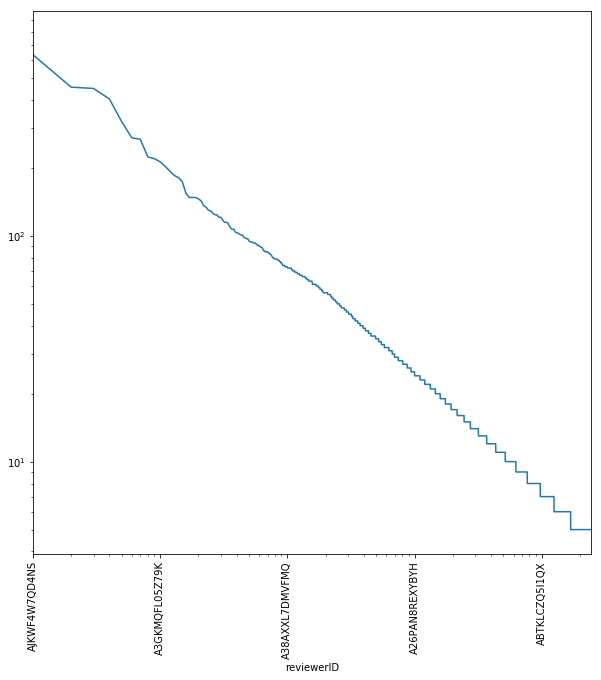

In [24]:
warnings.simplefilter('ignore') # Ignoring warning about non positive xlimit

count_evaluations.plot(logy=True, logx=True, rot=90, figsize=(10, 10));

We indeed have a power law.

### Analysis of the more productive reviewer

Focusing on the best evaluator, let's see if he provides well rated evaluations:

In [25]:
best_reviewer_id = top_count_evaluations.index[0]

print('Number of reviews: ' + str(video_games.groupby('reviewerID').get_group(best_reviewer_id).overall.count()))
video_games.groupby('reviewerID').get_group(best_reviewer_id).median()

Number of reviews: 773


overall            5.000000
helpfulRate        0.888889
helpfulCount       9.000000
rank            8736.000000
price             29.990000
dtype: float64

Comparing it with the other reviewers:

In [26]:
video_games.overall.median()

5.0

In [27]:
video_games[video_games.helpfulRate >= 0].helpfulRate.median()

0.6956521739130435

The best evaluator seems to be a normal person, his `helpfulRate` is above to the median (allowing to believe he does not flooded the products with fake reviews). He also gave more than 50% of 5 star grades. We don't get a lot of information here.

## Correlations

We add columns `reviewLength`, `summaryLength` and `reviewerNameLength` to the dataframe to take into account more metrics.

In [28]:
video_games['reviewLength'] = video_games['reviewText'].str.len()
video_games['summaryLength'] = video_games['summary'].str.len()
video_games['reviewerNameLength'] = video_games['reviewerName'].str.len()

video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A3UR8NLLY1ZHCX        4   
           A1INA0F5CWW3J4        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  helpfulCount  rank  \
asin       reviewerID                                                   
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  6629   
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000             0  6629   
           A1INA0F5CWW3J4 2014-06-28    -1.000000             0  6629   
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  6629   
           A361M14PU2GUEG 2011-06-14     1.000000             2  6629   

                                                                 description  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Dirt 3 is a popular rally racing game for Play...   
           A3UR8NLLY1ZHCX  Dirt 3 is a popular rally racing game for Play...   
           A1INA0F5CWW3J4  Dirt 3 is a popular rally racing game for Play...   
           A1DLMTOTHQ4AST  Dirt 3 is a popular rally racing game for Play...   
           A361M14PU2GUEG  Dirt 3 is a popular rally racing game for Play...   

                            price title brand  reviewLength  summaryLength  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN  246.63                       779             40   
           A3UR8NLLY1ZHCX  246.63                       304             15   
           A1INA0F5CWW3J4  246.63                       282              9   
           A1DLMTOTHQ4AST  246.63                      3489             47   
           A361M14PU2GUEG  246.63                       294              6   

                           reviewerNameLength  
asin       reviewerID                          
0700099867 A2HD75EMZR8QLN                 3.0  
           A3UR8NLLY1ZHCX                34.0  
           A1INA0F5CWW3J4                26.0  
           A1DLMTOTHQ4AST                 8.0  
           A361M14PU2GUEG                28.0

Before displaying the correlations, let's study how review's length are distributed (we only take into account reviews with at least one word).

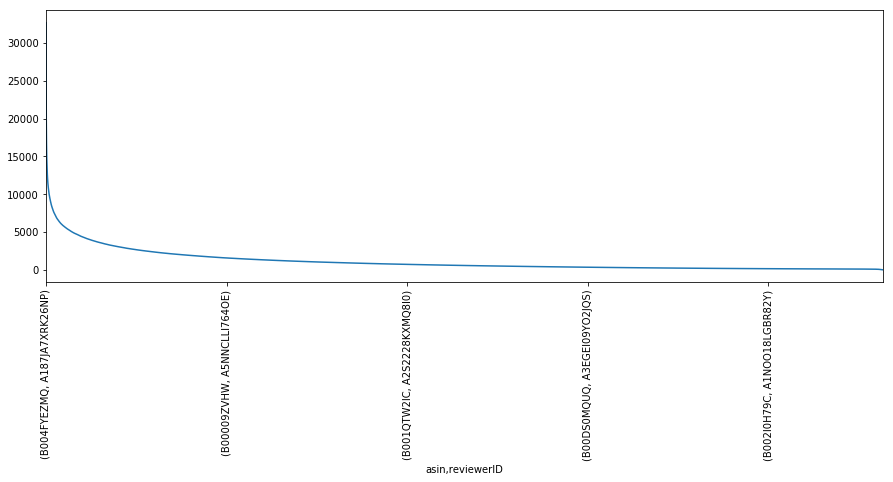

In [29]:
reviews_length = video_games[video_games.reviewLength > 0].reviewLength.sort_values(ascending=False)
reviews_length.plot(rot=90, figsize=(15, 5))

In [30]:
reviews_length.describe()

count    231736.000000
mean       1134.123628
std        1567.258380
min           3.000000
25%         235.000000
50%         576.000000
75%        1373.000000
max       32689.000000
Name: reviewLength, dtype: float64

As we can see, 50% of reviews have less than 576 words and 75% have less than 1373 words.

We display the correlation matrix and scatter plot:

In [31]:
video_games.corr()

,overall,helpfulRate,helpfulCount,rank,price,reviewLength,summaryLength,reviewerNameLength
overall,1.000000,-0.133272,-0.086515,-0.103580,0.054490,-0.062702,-0.074934,-0.009812
helpfulRate,-0.133272,1.000000,0.121019,0.111745,0.024150,0.294168,0.176459,0.099486
helpfulCount,-0.086515,0.121019,1.000000,-0.004194,0.007926,0.132578,0.056005,0.024202
rank,-0.103580,0.111745,-0.004194,1.000000,-0.044552,0.025594,0.024808,0.068894
price,0.054490,0.024150,0.007926,-0.044552,1.000000,0.018523,0.021714,0.011590
reviewLength,-0.062702,0.294168,0.132578,0.025594,0.018523,1.000000,0.309684,0.098276
summaryLength,-0.074934,0.176459,0.056005,0.024808,0.021714,0.309684,1.000000,0.094540
reviewerNameLength,-0.009812,0.099486,0.024202,0.068894,0.011590,0.098276,0.094540,1.000000


We plot the scatter matrix for each columns to avoid to fall in some bias (e.g. Simpson's paradox) by just looking at the correlation table.

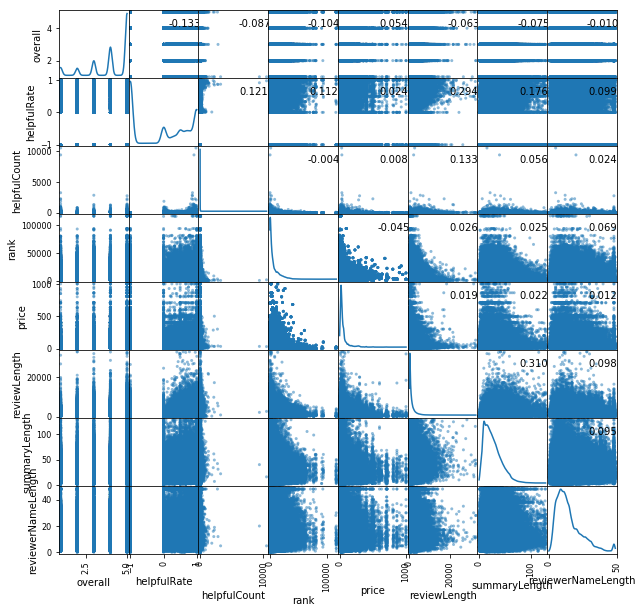

In [32]:
from pandas.tools.plotting import scatter_matrix

axes = scatter_matrix(video_games, alpha=0.5, diagonal='kde', figsize=(10, 10))
corr = video_games.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

plt.show()

- There is some correlation between between `reviewLength` and the `helpfulRate`. We can think that more the `reviewLength` is high, more the review can contain more descriptions and arguments, so it can increase the helpfullness.   
- Then, the `summaryLength` and the `reviewLength` seems to be also correlated. The more the review text is lengthy, the more the summary needs letters to summarize it.

## Serialize video_games using pickle

In [33]:
import pickle

with open('pickle/video_games.pkl', 'wb') as output:
    pickle.dump(video_games, output, pickle.HIGHEST_PROTOCOL)

## Words occurences

To do our `reviewText` words occurences, we will use the product which has the most reviews "PlayStation 4 500GB Console"

### Unigram

We print the top 10 words for each review grouped by the overall score.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def get_top_words(text_series, ngram):
    word_vectorizer = CountVectorizer(ngram_range=(ngram, ngram), analyzer='word', stop_words='english')
    sparse_matrix = word_vectorizer.fit_transform(text_series)
    frequencies = sum(sparse_matrix).toarray()[0]
    bigrams_freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by=['frequency'], ascending=False)

    bigrams_freq = bigrams_freq.iloc[0:10]

    return bigrams_freq.index


top_words_per_overall = pd.DataFrame()

for i in range(5):
    top_words_per_overall["Score " + str(i+1)] = get_top_words(most_reviewed_reviews[most_reviewed_reviews.overall == (i+1)].reviewText, 1)
top_words_per_overall

,Score 1,Score 2,Score 3,Score 4,Score 5
0,ps4,ps4,ps4,ps4,ps4
1,sony,games,games,games,games
2,console,ps3,ps3,like,console
3,just,sony,sony,controller,controller
4,xbox,console,like,game,ps3
5,amazon,just,just,ps3,game
6,games,play,console,just,like
7,34,like,game,console,xbox
8,work,does,play,sony,great
9,like,really,controller,better,just


The words are kind of neutral, there is not real positive or negative sentiment word. Except for "great" for Score 5 but only at 9th position. We were waiting for the postive word to be more in Score 5 and negative Score 1. The top word for each overall score is "ps4" which is the product name.

But only one word can miss some context, it's a better idea to search for multiple words.

### Bigram

So we now display the top bigram

In [35]:
top_words_per_overall = pd.DataFrame()
for i in range(5):
    top_words_per_overall["Score " + str(i+1)] = get_top_words(most_reviewed_reviews[most_reviewed_reviews.overall == (i+1)].reviewText, 2)
top_words_per_overall

,Score 1,Score 2,Score 3,Score 4,Score 5
0,blue light,blu ray,touch pad,hard drive,xbox 360
1,safe mode,ps3 ps4,hard drive,play games,free games
2,hard drive,steam pc,ps4 does,free games,user interface
3,doesn work,firmware update,ps3 ps4,new controller,hard drive
4,light death,looking forward,like ps3,blu ray,remote play
5,customer service,incremental services,blu ray,xbox 360,games like
6,blinking blue,pc games,better ps3,games like,games look
7,59 99,ps2 ps3,sony support,remote play,ps plus
8,xbox ps4,ability play,looks like,blue light,play games
9,launch day,usb port,feel like,just like,blu ray


Unfortunately, two words does not capture the sentiment of the review. The most of the outputed bigram are just common nouns. We can't say by having just "xbox 360" or "blue light" determine if the score will be 5 or 1.

## Machine learning exploratory

We now use some machine learning methods to improve our analysis.

### TF-IDF 
We transform the review text to TF-IDF features to to the clustering

In [36]:
vectorizer = TfidfVectorizer(stop_words = 'english', min_df=5)
tfidf_matrix = vectorizer.fit_transform(most_reviewed_reviews.reviewText)

#### Clustering attempt

We try to determine if the occurences of certain word are specific to the a certain score. We try to cluster, using unsupervised learning, the reviews based on the tf-idf features to 5 groups. We hope we will find on each group the same overall score : 1 group for review score 1, another for score 2 etc...

##### KMeans

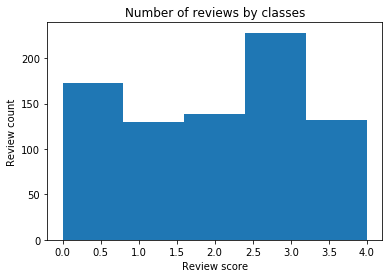

In [37]:
from sklearn.cluster import KMeans

k = 5
km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5)
km.fit(tfidf_matrix)

plt.hist(km.labels_, bins=k)
plt.xlabel('Review score')
plt.ylabel('Review count')

plt.title('Number of reviews by classes')
plt.show()

In [38]:
clusters = {}

for i in set(km.labels_):
    cluster = [most_reviewed_reviews.iloc[x] for x in np.where(km.labels_ == i)[0]]
    clusters[i] = pd.DataFrame(cluster)

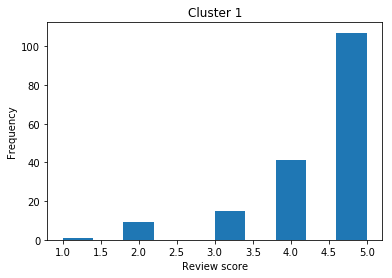

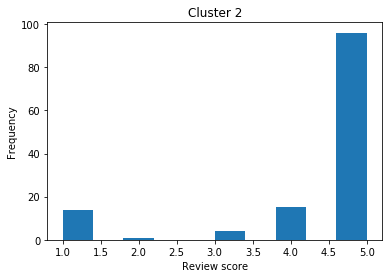

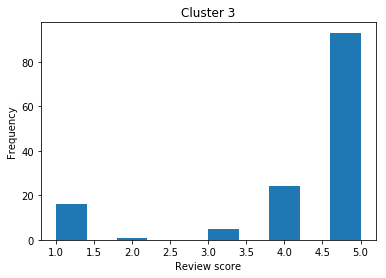

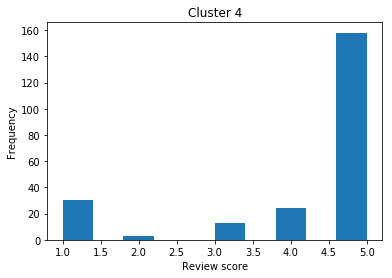

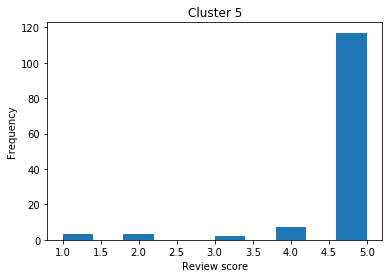

In [39]:
plt.title("Cluster 1")
plt.xlabel('Review score')
clusters[0].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 2")
plt.xlabel('Review score')
clusters[1].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 3")
plt.xlabel('Review score')
clusters[2].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 4")
plt.xlabel('Review score')
clusters[3].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 5")
plt.xlabel('Review score')
clusters[4].overall.plot(kind="hist");
plt.show()

It's not a great success. We dont have in each cluster only review with same score, but a mix. TF-IDF is unstable for such short document lengths.

<hr />

This is the beggining of the work for milestone 3.

## Deeper analysis

### Regression model

#### Linear regression

We will now try to do some `helpfulRate` prediction using simple linear regression. We start by producting a scatter plot based on the insights we found previously. More precisely, we will here visualize the `helpfulRate` compared to the `reviewLength` to see if we can visually anticipate a linear correlation between the two:

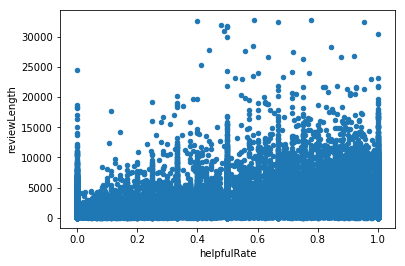

In [40]:
video_games[video_games.helpfulRate >= 0].plot(kind='scatter', x='helpfulRate', y='reviewLength')

We can see that it does not seem to have an explicit linear correlation here. We can still do the linear regression, as it is simple to implement. We, however, expect poor result here.

In [41]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

lreg = linear_model.LinearRegression()

X = video_games[video_games.helpfulRate >= 0].loc[:,['reviewLength', 'summaryLength', 'rank', 'overall']]
x_train, x_cv, y_train, y_cv = train_test_split(X,video_games[video_games.helpfulRate >= 0].helpfulRate)

lreg.fit(x_train,y_train)
pred = lreg.predict(x_cv)

explained_variance_score(y_cv, pred)

0.12411981897969659

After several testings on multiple features, we found the best features combination to get a `variance score` of about 0.12. This is a really poor result considering the best possible score is 1.0.

### Classification

The task to predict directly a continuous value for the `helpfulRate` seems to be too complicated. We switched to a classification task, predicting if the review is `helpful` or `not helpful`.

Let's plot the distribution of the helpfulness.

In [391]:
# We only analyse reviews with an helpful rate...
helpful_video_games = video_games[video_games.helpfulRate >= 0]

# We also take only reviews with a minimum of three evaluations, to avoid bias
helpful_video_games = helpful_video_games[video_games.helpfulCount > 3]

# We clusterize our data into two categories: helpful and non-helpful reviews
helpful_video_games['wasHelpful'] = helpful_video_games['helpfulRate'].apply(lambda x: 'helpful' if x > 0.5 else 'notHelpful')

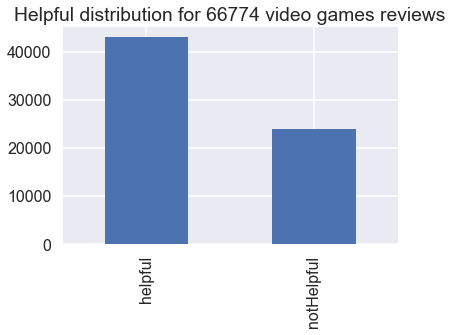

In [392]:
groupby_helpful = helpful_video_games.groupby('wasHelpful')

groupby_helpful['overall'].count().plot.bar(title='Helpful distribution for ' + str(len(helpful_video_games)) + ' video games reviews');
ax1 = plt.axes()
ax1.xaxis.label.set_visible(False)
plt.show()

We can see that there are a lot more helpful review than not helpful. We are facing to an imbalanced dataset. So we will use the `f1-score` metrics to evaluate our future models. We will use `macro` average because we want to give the same importance to each classes.

There are many features that we can take into account for our classification task, including for example using the review text itself. However, we will first use a simple neural networks model and basic features to see the behaviour.

#### First draft with basic features

Considering the data distribution, usage of linear regression seems to be innapropriate. We chose to change completely our strategy by using neural networks. As we have important data aggregates, we may succeed in training a neural network to predict helpfulness.

##### Using only overall
We start by a naive approach, by trying to predict if a review was helpful only using the `overall` feature; meaning answering the question: "How well can we predict if a review is helpful based on the review grade?"

In [498]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

label_encoder = LabelEncoder()
label_encoder.fit_transform(helpful_video_games['wasHelpful'])
    
def train_network(dataset, features, max_iter, predict=False):
    y = dataset['wasHelpful']
    y = label_encoder.fit_transform(y)
    
    x = dataset.loc[:, features]

    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25)

    clf = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=max_iter, alpha=0.0001,
                     solver='sgd', verbose=False,  random_state=21, tol=0.000000001)

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    if predict:
        print("f1-score:", f1_score(y_test, y_pred, average='macro'))
   

    
    return clf, x, y

In [499]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
    
clf, x, y = train_network(helpful_video_games, ['overall'], 20, True)

f1-score: 0.638557252743


The f1-score is around 0.63 by only taking into account the initial rate, which is clearly better than a simple linear regression. Let's find out how our classifier works...

In [479]:
for i in range(1, 6):
    print(str(i) + ' star review: ' + str(label_encoder.inverse_transform(clf.predict(i))))

1 star review: ['notHelpful']
2 star review: ['notHelpful']
3 star review: ['helpful']
4 star review: ['helpful']
5 star review: ['helpful']


We get here a new insight about data distribution. One star reviews seems to have a lower helpful rate than other reviews. This may be due to overstated reviews and product bashing. Let's do a short descriptive analysis to confirm this new information.

Because we know we have high differences in the number of evaluations in each grade category, we use the standard error instead of the standard deviation to draw the error bars. This allows to mitigate the observations.

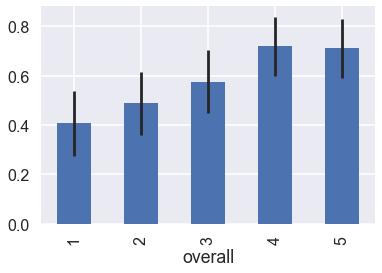

In [480]:
grouped_helpful_reviews = helpful_video_games.groupby(['overall']).helpfulRate
grouped_helpful_reviews.mean().plot(kind='bar', yerr=grouped_helpful_reviews.std()/math.sqrt(len(grouped_helpful_reviews)));

We can see that errors are important, due to the high variance of the results. This may be explained by the fact that using the overall only to find the final rank is not as good as taking multiple features into account.

After seing this plot and data distribution, we can understand why only 1 star reviews are getting are immediately considered as not helpful. We now cross validate to ensure results were representative of the reality.

In [500]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, x, y, cv=4, scoring='f1_macro')
print("crossval f1-score:", np.mean(scores))

crossval f1-score: 0.617901082767


After cross-validation, we get even less: f1-score=0.61.

However, predicting the helpfulness of a review by sorting it as `true` or `false` based on the grade is not very helpful and creates an unwanted segregation in data. Considering Amazon would use these results to promote specific reviews, it may create an incentive for posting fake 5 star reviews to be put forward.

###### Predicting 3 class

Before testing against more features, we will create three clusters to determine if a review was helpful:

- 0 will mean the review is not helpful at all (less than 33% of the evaluations said it was useful)
- 1 will mean the review may be polemical (less than 66% of the evaluations said it was useful)
- 2 will mean the review was useful (more than 66% of the evaluations said it was useful)

Lets plot the distribution

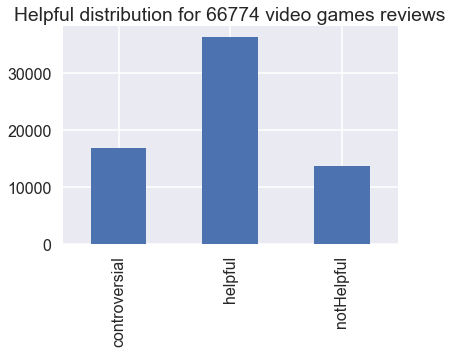

In [482]:
helpful_video_games2 = helpful_video_games.copy()
helpful_video_games2['wasHelpful'] = helpful_video_games.helpfulRate.map(lambda x: 'notHelpful' if x < 0.33 else 'controversial' if x < 0.66 else 'helpful')

label_encoder2 = LabelEncoder()
label_encoder2.fit_transform(helpful_video_games2['wasHelpful'])

groupby_helpful = helpful_video_games2.groupby('wasHelpful')

groupby_helpful['overall'].count().plot.bar(title='Helpful distribution for ' + str(len(helpful_video_games2)) + ' video games reviews');
ax1 = plt.axes()
ax1.xaxis.label.set_visible(False)
plt.show()

We see that ther are still more helpful review than the others type, the dataset is still imbalanced.

Let's retest with our **using only overall** feature:

In [501]:
clf, x, y = train_network(helpful_video_games2, ['overall'], 100)
scores = cross_val_score(clf, x, y, cv=4, scoring='f1_macro')
print("crossval f1-score:", np.mean(scores))

crossval f1-score: 0.399567548002


The f1-score of our network dropped significantly. Let's find out how he classified our data:

In [484]:
for i in range(1, 6):
    print(str(i) + ' star review: ' + str(label_encoder2.inverse_transform(clf.predict(i))))

1 star review: ['notHelpful']
2 star review: ['helpful']
3 star review: ['helpful']
4 star review: ['helpful']
5 star review: ['helpful']


We can see that our neural networks is limited here, and have some difficulties determining when the reviews should be "polemical".
##### Using only reviewLength
We will now introduce more features to see if we can improve our f1-score score which dropped a lot.

In [502]:
# We increase the number of iterations as we have a higher scope of possibilities
clf, x, y = train_network(helpful_video_games2, ['reviewLength'], 1000)
scores = cross_val_score(clf, x, y, cv=4, scoring='f1_macro')
print("crossval f1-score:", np.mean(scores))

crossval f1-score: 0.235087840403


In [159]:
for i in range(0, 100000):
    if clf.predict(i)[0] != label_encoder2.transform(['helpful'])[0]:
        print(i)

We can see with the previous code that our classifer always return *helpful* as the level of helpfulness of the review; it does not find any trends in the dataset.

##### Using only summaryLength

By using only the review length, we get a really lower range. It is not possible, only considering the review length, to determine if it would be helpful. We will need to go deeper and analyse the review contents.

In [1]:
clf, x, y = train_network(helpful_video_games2, ['summaryLength'], 1000)
scores = cross_val_score(clf, x, y, cv=3, scoring='f1_macro')
print("crossval f1-score:", np.mean(scores))

crossval f1-score: 0.235138637116


Our 3-class `helpful`, `notHelpful` and `controversial` predictions ares not very good. We will go back to an easier task, the binary classification `helpful` and `notHelpful`.

#### More features and analysis

We already have the `overall`, `reviewLength` and `summaryLength`.

We will start now with more features declined from text to increase our prediction scores :
- **exclamationCount** : A text with a lot of "!" probably written by a irritated guy
- **questionCount** : Maybe including questions in the review can impact the helpfulness
- **threeDotsCount** : The elipsis mark can signify some fed-up from the reviewer
- **uppercaseCount** : A review written in full CAPS-LOCK can be considered as a bad review

We add also these products related features :
- **price** : A product with a high price might have better quality review ?

In [414]:
# Add features
helpful_video_games['exclamationCount'] = helpful_video_games['reviewText'].str.count('!') + helpful_video_games['summary'].str.count('!')
helpful_video_games['questionCount'] = helpful_video_games['reviewText'].str.count('\?') + helpful_video_games['summary'].str.count('\?')
helpful_video_games['threeDotsCount'] = helpful_video_games['reviewText'].str.count('\.\.\.') + helpful_video_games['summary'].str.count('\.\.\.')
helpful_video_games['uppercaseCount'] = helpful_video_games['reviewText'].str.count('[A-Z]') + helpful_video_games['summary'].str.count('[A-Z]')

helpful_video_games[['reviewText','wasHelpful', 'exclamationCount', 'questionCount', 'threeDotsCount', 'uppercaseCount']].head()

reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           AN3YYDZAS3O1Y   Loved playing Dirt 2 and I thought the graphic...   
           AQTC623NCESZW   I can't tell you what a piece of dog**** this ...   
           A10AYT89XSCE46  This game is bug landFirst had problems instal...   

                           wasHelpful  exclamationCount  questionCount  \
asin       reviewerID                                                    
0700099867 A2HD75EMZR8QLN     helpful                 1              2   
           A1DLMTOTHQ4AST     helpful                 2              0   
           AN3YYDZAS3O1Y      helpful                 2              0   
           AQTC623NCESZW   notHelpful                 0              0   
           A10AYT89XSCE46  notHelpful                 2              0   

                           threeDotsCount  uppercaseCount  
asin       reviewerID                                      
0700099867 A2HD75EMZR8QLN               0              27  
           A1DLMTOTHQ4AST               0              60  
           AN3YYDZAS3O1Y                3              23  
           AQTC623NCESZW                0              22  
           A10AYT89XSCE46               0              26

Let's plot how these features separate the reviews helpfulness

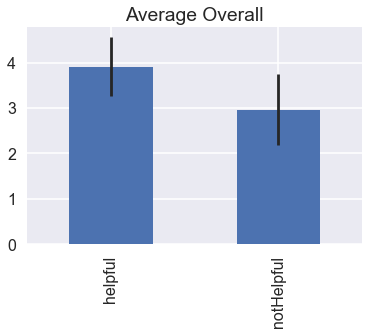

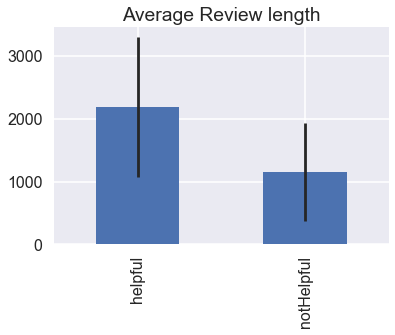

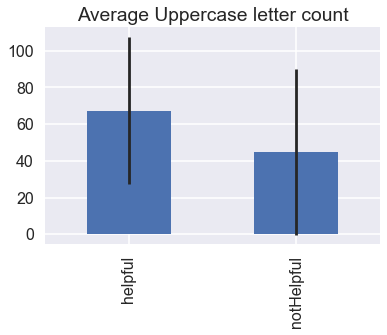

In [335]:
groupby_helpful = helpful_video_games.groupby('wasHelpful')

def plot_bar_chart(title, column):
    groupby_helpful[column].mean().plot.bar(title=title, yerr=groupby_helpful[column].std()/2);
    ax1 = plt.axes()
    ax1.xaxis.label.set_visible(False)
    plt.show()
    
plot_bar_chart('Average Overall', 'overall')
plot_bar_chart('Average Review length', 'reviewLength')
plot_bar_chart('Average Uppercase letter count', 'uppercaseCount')

We see that the feature `reviewLength` "separate" the most, and so gives the most information about that. The others features `overall` and `uppercase count` are give little less but still acceptable.

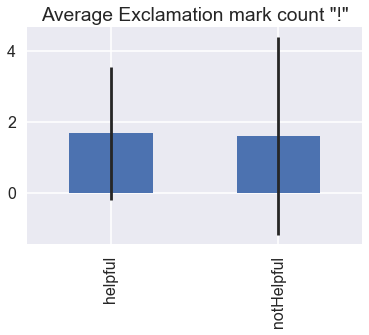

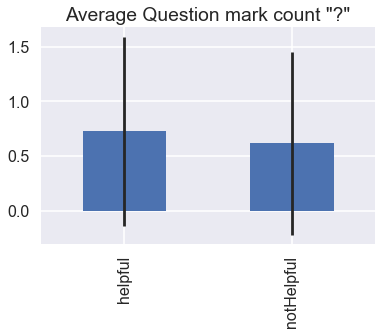

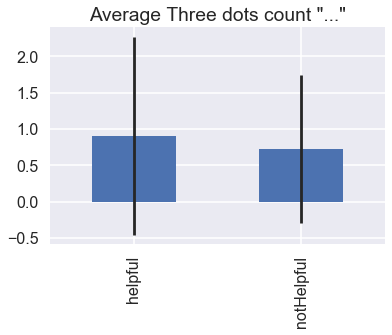

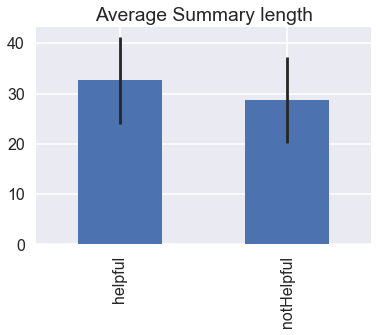

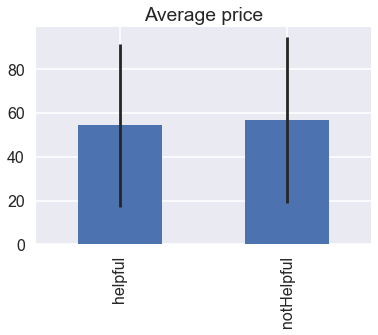

In [336]:
plot_bar_chart('Average Exclamation mark count "!"', 'exclamationCount')
plot_bar_chart('Average Question mark count "?"', 'questionCount')
plot_bar_chart('Average Three dots count "..."', 'threeDotsCount')
plot_bar_chart('Average Summary length', 'summaryLength')
plot_bar_chart('Average price', 'price')

We are more mitigated concerning the `threeDotsCount`, `questionCount`, `exclamationCount`. We see that there is a low usage of these in the review. Then `summaryLength` and `price` separate also separate poorly the helpfulness. These are probably bad features. 
But maybe the combinations of these with others features can give us a lot of information concerning the helpfulness. We will see later.


We now have 8 features. We will start now using words embeddings to exploit the full potential of the content of each review.

#### Text features : word2vec
To use the word2vec embeddings, we need to train the a model with our review text words.

Let's first obtain these words by tokenization.

##### Text preprocessing

We create a NLTK preprocessor, sklearn pipeline compatible, that will have the job to preprocess our text :
- Break the raw text into sentences
- Divide the sentences into words
- Convert to lower case
- Remove the english stopwords and punctuation
- Lemmatize each tokens

In [182]:
# Source: https://bbengfort.github.io/tutorials/2016/05/19/text-classification-nltk-sckit-learn.html

class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, document):
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If stopword, ignore token and continue
                if token in self.stopwords:
                    continue

                # If punctuation, ignore token and continue
                if all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

In [190]:
print('Original review text:')
print(helpful_video_games.iloc[19].reviewText)
print()
print('Preprocessed text:')
print(NLTKPreprocessor().transform([helpful_video_games.iloc[19].reviewText])[0])

Original review text:
I purchased these for my Wii as Nintendo no longer produces Wavebird controllers by virtue of them being sued by a patent owner over the technology. I didn't want to pay for a used Wavebird on eBay, so I bought some of these. I sit back from my HDTV about 9 feet so I needed these for the wired Gamecube controllers and they work very well. Even with Mario Kart Wii, there is some lag with the Wavebird, but there is no lag with these extension cables. Highly recommended!

Preprocessed text:
['purchase', 'wii', 'nintendo', 'longer', 'produce', 'wavebird', 'controller', 'virtue', 'sue', 'patent', 'owner', 'technology', 'want', 'pay', 'used', 'wavebird', 'ebay', 'buy', 'sit', 'back', 'hdtv', '9', 'foot', 'need', 'wired', 'gamecube', 'controller', 'work', 'well', 'even', 'mario', 'kart', 'wii', 'lag', 'wavebird', 'lag', 'extension', 'cable', 'highly', 'recommended']


##### Training the word2vec model
(This part has been done in another [notebook](https://nbviewer.jupyter.org/github/Coac/epfl-ada/blob/master/Project/Helpful%20score%20prediction.ipynb#Train-w2v) to avoid to surcharge this main notebook)

We trained it with all the review and summary text (1,868,601 raw sentences) from all the video games review.
The vocabulary length is 59397.


We will just load the trained model.



In [191]:
import gensim
w2v_model = gensim.models.word2vec.Word2Vec.load("w2v/video_games.w2v")
print("Model loaded")

Model loaded


Let's now plot the words into a 2d-space

In [192]:
count = 10000
word_vectors_matrix = np.ndarray(shape=(count, 300), dtype='float64')
word_list = []
i = 0
for word in w2v_model.wv.vocab:
    word_vectors_matrix[i] = w2v_model[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

# Compress the word vectors into 2D space
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)
print("Points DataFrame built")
points.head()

word_vectors_matrix shape is  (10000, 300)
word_vectors_matrix_2d shape is  (10000, 2)
Points DataFrame built


,word,x,y
0,instal,-6.611094,60.431065
1,game,-20.650276,33.084148
2,struggle,16.045649,4.731496
3,window,-15.079869,59.436687
4,live,-11.985738,8.099268


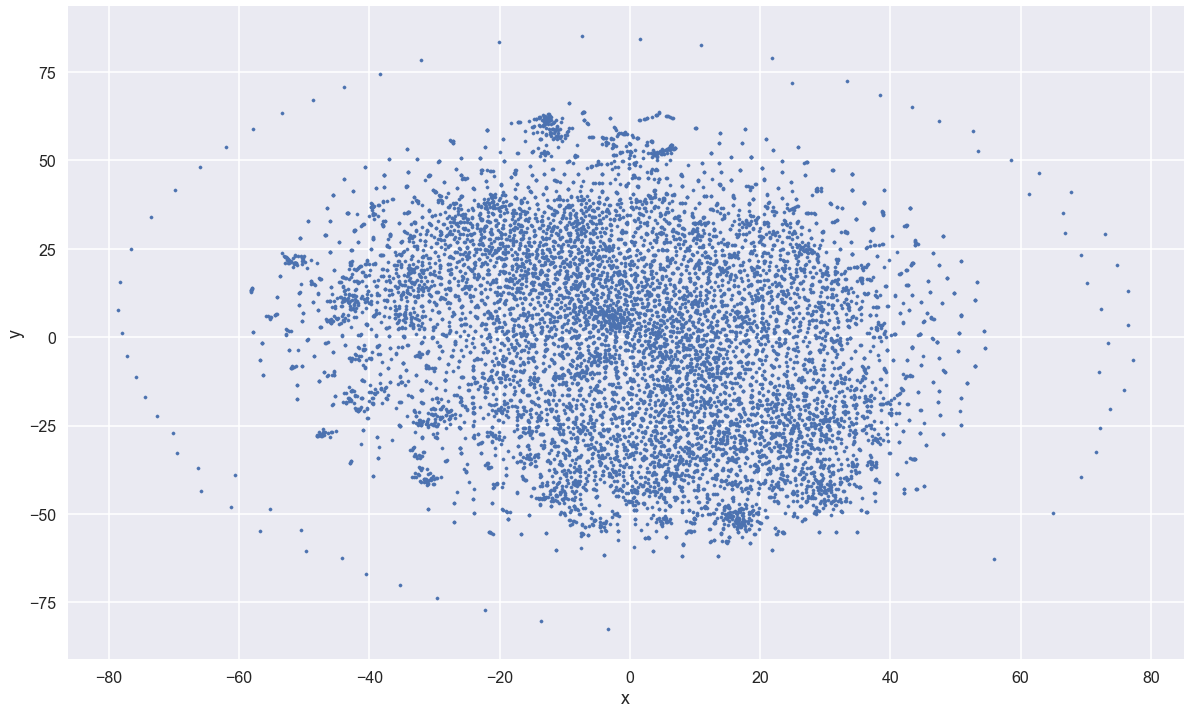

In [287]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12));

We can zoom into a certain region to see which words are close to each others.

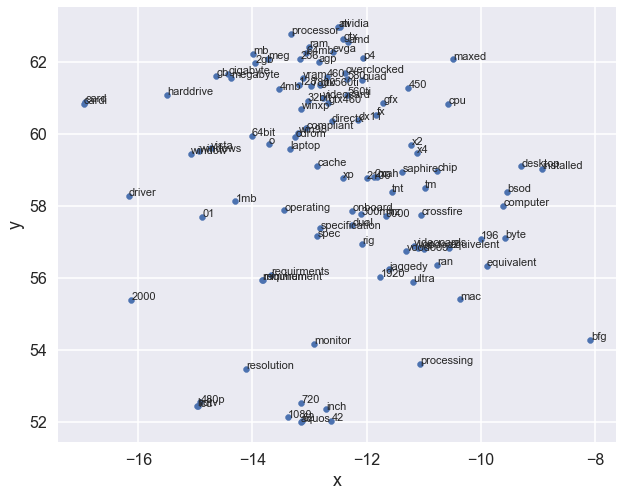

In [355]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) 
    ]
     
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
        
    return ax

plot_region(x_bounds=(-17, -8), y_bounds=(52, 66));

We zoomed to a cluster than contain a word related to hardware/PC.

Let's try to get some similar words of "mario" word :

In [256]:
w2v_model.wv.most_similar("mario")

[('bros', 0.7767923474311829),
 ('kart', 0.7274721264839172),
 ('luigi', 0.6836210489273071),
 ('sunshine', 0.6641625165939331),
 ('nsmb', 0.6625683307647705),
 ('wiimario', 0.6515724062919617),
 ('smb', 0.6476815342903137),
 ('nsmb2', 0.6301655173301697),
 ('marioworld', 0.6247094869613647),
 ('mariokart', 0.6150649785995483)]

The results are coherent. The output words are all related to the mario games.

##### Using the word2vec features

We create a sklearn compatible vectorizer for word2vec. 

As the review text contains multiple words, we will use an average of the word2vec vectors.

In [197]:
import collections
# Modified for python 3 from https://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [198]:
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))
w2v_vectorizer = MeanEmbeddingVectorizer(w2v)


##### The model

We create now the classification pipeline with the NTLK preprocessor and the word2vec vectorizer for the text.

The pipeline includes also the others features.

In [239]:
from sklearn.svm import SVC

class MultipleItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        self.keys = keys

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        if not isinstance(data_dict[:, self.keys][0], str):
            return np.array(list(data_dict[:, self.keys])).reshape(len(data_dict), 1)
        return data_dict[:, self.keys]

def create_pipeline(classifier=SGDClassifier):
    if isinstance(classifier, type):
        classifier = classifier()

    model = Pipeline([
        ('union', FeatureUnion(
            transformer_list=[
                ('summary', Pipeline([
                    ('selector', MultipleItemSelector(keys=0)),
                    ('preprocessor', NLTKPreprocessor()),
                    ('vectorize', w2v_vectorizer),
                ])),
                ('reviewText', Pipeline([
                    ('selector', MultipleItemSelector(keys=1)),
                    ('preprocessor', NLTKPreprocessor()),
                    ('vectorize', w2v_vectorizer),
                ])),
                ('reviewText_length', Pipeline([
                    ('selector', MultipleItemSelector(keys=2)),
                ])),
                ('overall', Pipeline([
                    ('selector', MultipleItemSelector(keys=3)),
                ])),
                ('exclamationCount', Pipeline([
                    ('selector', MultipleItemSelector(keys=4)),
                ])),
                ('questionCount', Pipeline([
                    ('selector', MultipleItemSelector(keys=5)),
                ])),
                ('threeDotsCount', Pipeline([
                    ('selector', MultipleItemSelector(keys=6)),
                ])),
                ('uppercaseCount', Pipeline([
                    ('selector', MultipleItemSelector(keys=7)),
                ])),
                ('summaryLength', Pipeline([
                    ('selector', MultipleItemSelector(keys=8)),
                ])),
                ('price', Pipeline([
                    ('selector', MultipleItemSelector(keys=9)),
                ])),
                
            ],
            transformer_weights={
                'summary': 1.0,
                'reviewText': 1.0,
                'reviewText_length': 1.0,
                'overall': 1.0,
                'exclamationCount': 1.0,
                'questionCount': 1.0,
                'threeDotsCount': 1.0,
                'uppercaseCount': 1.0,
                'summaryLength': 1.0,
                'price': 1.0,

            },
        )),

        ('classifier', classifier),
    ])
        

    return model


We create our X (features + word2vec) and ou y (helpful or not) for our classification.

In [351]:
label_encoder = LabelEncoder()
label_encoder.fit(helpful_video_games.wasHelpful.values)
features_name = ['summary', 'reviewText', 'reviewLength', 'overall', 'exclamationCount', 'questionCount', 'threeDotsCount', 'uppercaseCount', 'summaryLength', 'price']

def get_X_Y_from_df(helpful_video_games, test_size=0.2):
    X = helpful_video_games.summary.values
    X = X.reshape(len(X), 1)
    X = np.append(X, np.array(helpful_video_games.reviewText.values).reshape(len(X), 1), 1)
    X = np.append(X, np.array(helpful_video_games.reviewLength.values).reshape(len(X), 1), 1)
    X = np.append(X, np.array(helpful_video_games.overall.values).reshape(len(X), 1), 1)

    X = np.append(X, np.array(helpful_video_games.exclamationCount.values).reshape(len(X), 1), 1)
    X = np.append(X, np.array(helpful_video_games.questionCount.values).reshape(len(X), 1), 1)
    X = np.append(X, np.array(helpful_video_games.threeDotsCount.values).reshape(len(X), 1), 1)
    X = np.append(X, np.array(helpful_video_games.uppercaseCount.values).reshape(len(X), 1), 1)
    X = np.append(X, np.array(helpful_video_games.summaryLength.values).reshape(len(X), 1), 1)
    X = np.append(X, np.array(helpful_video_games.price.values).reshape(len(X), 1), 1)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(helpful_video_games.wasHelpful.values)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [540]:
# We use all the available reviews
X_train, X_test, y_train, y_test = get_X_Y_from_df(helpful_video_games)

We will use the Gradient Boosting classifier to do our task, it's widely use and provides in general good accuracy.  
(The following cell takes more than 1 hour to compute because of the number of reviews ~66k)

In [432]:
clf = GradientBoostingClassifier()

model = create_pipeline(classifier=clf)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print("Train F1-score:", f1_score(y_train, y_pred, average="macro"))

y_pred = model.predict(X_test)
print("Test F1-score:", f1_score(y_test, y_pred, average="macro"))

Train F1-score: 0.7296546205
Test F1-score: 0.714394884311


Our f1-score better than our draft model.

We plot now the confusion matrices for the test set :

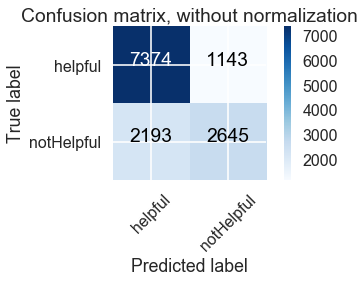

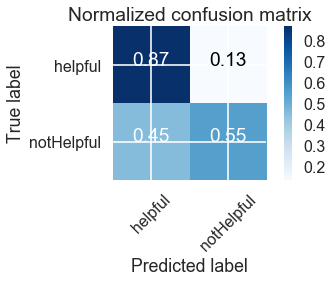

In [463]:
plots_confusion_matrices(y_test, y_pred, label_encoder.classes_) # function from functions.py

We see that the scarce class `notHelpful` get a lower score.

We can now plot the features importance of theGradient Boosting classifier. For the word2vec features, we summed each composant of the vector to get its feature importance.

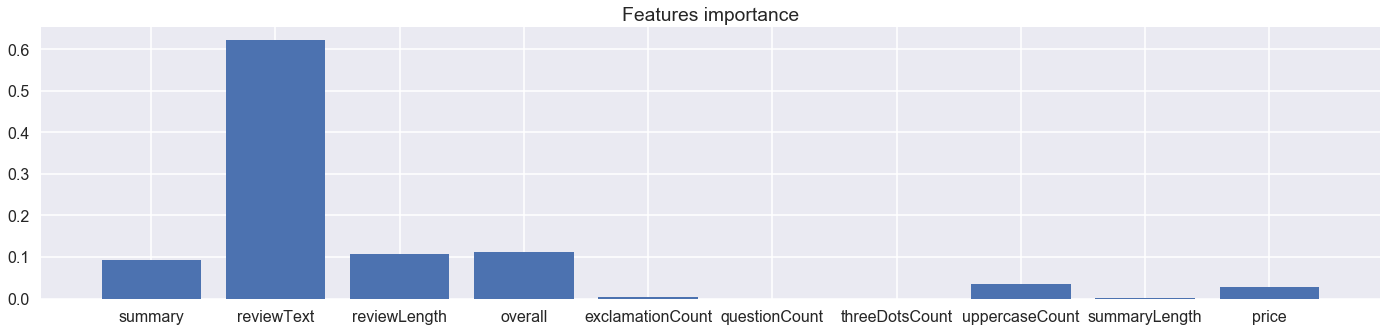

In [561]:
w2c_dim = 300
importants = []

importants.append(np.sum(clf.feature_importances_[0:w2c_dim]))
importants.append(np.sum(clf.feature_importances_[w2c_dim:w2c_dim*2]))

for i in range(w2c_dim*2, w2c_dim*2+8):
    importants.append(clf.feature_importances_[i])

plt.figure(figsize=(24, 5))


plt.bar(range(10), importants, align='center')
plt.xticks(range(10), features_name)
plt.title('Features importance')

plt.show()

We can see that the `questionCount` and `threeDotsCount` are not used by the classifier. Also the `exclamationCount` and `summaryLength` are quite low. These confirm what we said before from the previous plots. 

The `reviewText` contributes the most for our prediction.
Interpretation : The text that the reviewer write has some impact on the helpfullness. This seems to be logical.

We save our model for future usage

In [337]:
with open('pickle/trained_model.pkl', 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

However, because text preprocessing is taking a consequent time, it will be difficult to improve the model by tuning the parameters using Gridsearch and cross validation.

We can decrease the number of reviews.

##### Our trained model on 1000 PC games

Now we can test our trained model to a subset of the dataset : 1000 PC games.  
These games were selected using a *NearestNeighbour* method started from one PC game. You can check the method on our other notebook [Similar products.ipynb](https://github.com/Coac/epfl-ada/blob/master/Project/Similar%20products.ipynb)


In [539]:
with open('pickle/trained_model.pkl', 'rb') as output:
    model = pickle.load(output)

In [416]:
asins = ['B000810NAS', 'B004V7W3EO', 'B000WJOYAQ', 'B000J55YSE', 'B00001ZT4C', 'B002JZ7STU', 'B00025LDKO', 'B0007TYMLW', 'B00003IEL1', 'B000IK3XJW', 'B00HFTOTI8', 'B0046LVG3Y', 'B001514JP0', 'B000760OV2', 'B000GDAZXI', 'B00005JDNJ', 'B0000ZUA78', 'B00004UE0I', 'B000LO68JC', 'B000IO2HNQ', 'B00079MUXE', 'B000077W0H', 'B00004WI4B', 'B00HFU41OY', 'B000059XP2', 'B000RJTZTG', 'B001SN6YGC', 'B004BDBSQW', 'B0009HK2MK', 'B000056EZG', 'B009GFBRZ2', 'B0061ABD90', 'B005A2JVN0', 'B00002S7YP', 'B000IWQUO0', 'B00162L5OG', '1557556741', 'B000RS5C4E', 'B004KIV29G', 'B0012DPHKW', 'B0001PKEXM', 'B0017WKITS', 'B00079MVHY', 'B001QINBBK', 'B000NJFMR4', 'B000WA8V3Q', 'B000GJWGI4', 'B000KHIRCG', 'B000P59QE6', 'B002XNW6T0', 'B003SEKKRI', 'B000J14PBA', 'B001FS7FE0', 'B00005BU82', 'B000W2UHQ8', 'B000MQX8CO', 'B00005QCQM', 'B00004Y2MN', 'B00G2HSXL8', 'B000F1RFV6', 'B000PMPUVW', 'B000HCW0QI', 'B000663RU8', 'B00DJ427M8', 'B00CP1QA1U', 'B001BNDPO8', 'B000TV7QTS', 'B0077W6882', 'B005Y7ML3I', 'B001Q24UAM', 'B005G2TWT2', 'B004EIJHG2', 'B00002SW31', 'B00AYABX9I', 'B00003IEKQ', 'B00AQF345C', 'B00004T0QO', 'B00AQF317I', 'B00B5GZORW', 'B00AQF30XS', 'B009VURIHI', 'B003VUPTJS', 'B0030VKCVI', 'B001H0NPFY', 'B00130UXH6', 'B001IRFWJS', 'B004FLK3CA', 'B00001QEQW', 'B004CJB2UC', 'B0000645W3', 'B00EVVO1CM', 'B000AFKJLU', 'B007R06KSC', 'B00014WYOK', 'B000HWZYF2', 'B00002S6C7', 'B00005V13Z', 'B0002X5MEO', 'B0000EYVZQ', 'B00006JL1P', 'B00004TCUI', 'B00003IEEB', 'B004YU06J2', 'B0002SLAYA', 'B0000EZ0XS', 'B0002B1074', 'B003L7EKNC', 'B000TTIVA8', 'B000ES5S2S', 'B000088NRW', 'B0002ULC5K', 'B00004UE15', 'B00004XRZ0', 'B00002S6FD', 'B000ZPPPKU', 'B00007M9SN', 'B000RQHB5Y', 'B000EP3ZLC', 'B00001QEQA', 'B0015L74G6', 'B00D02ARRQ', 'B00007BGOG', 'B005CFDBF4', 'B0006BAXNC', 'B00003IELX', 'B0000DYLDC', 'B00019G50Y', 'B001AZMO76', 'B000J18SVI', 'B000JVWCK6', 'B00002S6EC', 'B000WWHEBO', 'B002WP4AZC', 'B0090WC246', 'B004PAGJMO', 'B00002CF8U', 'B0002BQRGS', 'B0050GZ0J0', 'B00BJEY9EO', 'B00BXE4W4C', 'B00BKWZ18I', 'B002JZ12EC', 'B002MFQKXM', 'B000WQ1XIA', 'B0043OIHCC', 'B004TJE4QE', 'B000YSYDOC', 'B00AR7GMHG', 'B000M38ADY', 'B000QB059E', 'B009ZVIMB4', 'B004TLLPZU', 'B000EXU98G', 'B0050SZ7LO', 'B001DBJGW8', 'B004W6O6AI', 'B002IRX8KC', 'B000FOZD5S', 'B000LUA6VW', 'B0018RWMRI', 'B00002K13E', 'B00FPH9M9S', 'B0009WPZM2', 'B00067ZEIK', 'B00H4BBTCQ', 'B0007W54X4', 'B000056W4I', 'B001AMGCYK', 'B0037BSTYS', 'B00017K08O', 'B000CSNKWU', 'B0040JGNKI', 'B001IKC3QA', 'B004UD0TC2', 'B00F4Q3HTG', 'B004GWVZWU', 'B00001LCDQ', 'B00002S8OT', 'B00005NZT1', 'B0000501B1', 'B000W8LY78', 'B004Y37O4E', 'B007RE76CW', 'B00002SSSF', 'B000930DOG', 'B00196HEIK', 'B002CZ3N3C', 'B0033WTK4O', 'B00B2QL2Y4', 'B0016PZYLS', 'B0016Q2172', 'B005BTC9WW', 'B000F9AP4C', 'B00002NDF7', 'B0029ZUPSQ', 'B000TTZI0E', 'B00G1DKOZ6', 'B00FJWNSWQ', 'B00CF3AKLY', 'B0085Q7ENC', 'B00008JV5G', 'B00DUCPWOY', 'B0031TG9DO', 'B000A6K6DU', 'B0042X8V6G', 'B001REZLYI', 'B000OFA4UW', 'B000R0URXI', 'B000XJO7A2', 'B00005KAY0', 'B001HC65BI', 'B0009ICISK', 'B00002S7YE', 'B0088VH8JE', 'B0034G5R46', 'B0012GUAII', 'B000924J2E', 'B001CU2SE8', 'B001OMU6VQ', 'B000YBW6BQ', 'B001URRH12', 'B002DC8GEK', 'B00005KG5D', 'B002V8KA72', 'B001HBTK8O', 'B001BTPRKC', 'B00009ADDO', 'B00005B43W', 'B00164AU8G', 'B000063N9P', 'B00000F1GK', 'B0001ILYQK', 'B006PDACWC', 'B003OZOAKY', 'B000KGD1GO', 'B002LE88MK', 'B0089X37NW', 'B00J337WNI', 'B00006471Z', 'B00002S78T', 'B007I531DI', 'B000P0QJ1E', 'B00004VX49', 'B00069ZINO', 'B005X6QNWU', 'B000H25YRA', 'B002NGL8M8', 'B000HJQY0Y', 'B000EDNRLC', 'B000OOOIXM', 'B000MAFXTQ', 'B000HKGIOA', 'B000E4FD9U', 'B009APQ9QU', 'B002Z7ELOW', 'B004PFS9OK', 'B004PFN52G', 'B000IO79MU', 'B00001LDBY', 'B00008K2Y3', 'B00001NFSY', 'B00008K2R2', 'B005CTCT76', 'B00006496H', 'B004R8M7AC', 'B00001IVB4', 'B00092CJL2', 'B00CPKUS00', 'B003Z0LFF6', 'B00005ARX4', 'B000ORJF6O', 'B000MK57SI', 'B00IEO41GS', 'B0006FHB74', 'B0002IBEQO', 'B001189HY0', 'B00004VXAX', 'B00008PGIE', 'B00007BGU3', 'B00004RBOT', 'B00FQPQO4A', 'B001GOXQY6', 'B00005AG1L', 'B000P46NK2', 'B0008G2B1C', 'B009GKT2M2', 'B00005V9DA', 'B000I7ZBBI', 'B0002CHIWY', 'B000021Y3X', 'B000067O90', 'B00005BF3V', 'B00002ST5S', 'B008BLOUPQ', 'B000BD3120', 'B00008XKZZ', 'B0002ER29Q', 'B00FQPQMTW', 'B0017XFP86', 'B00BM7NXMW', 'B00FXWJW0E', 'B00FQPQOPY', 'B00FQPQNDW', 'B0002NW8SW', 'B002NQ4820', 'B0009TTJ68', 'B00002SUBS', 'B000FBK6G2', 'B000KJVR9E', 'B00001ZUJW', 'B00005JD6H', 'B0028ZNX7M', 'B0002RQ3H0', 'B0001MBCDQ', 'B00004U5JA', 'B00004U8K5', 'B000KRRBEG', 'B000EBC0PI', 'B00001ZT3P', 'B00002S6EY', 'B00004UEVV', 'B00063BRYO', 'B00004SWM2', 'B000059TCG', 'B00005RKNC', 'B00005V5XH', 'B0056JCFEY', 'B00005ML8J', 'B00001ZUGG', 'B000809QMA', 'B00004SW0C', 'B000035Y9V', 'B0000A082Y', 'B0001I9YG2', 'B000IOD618', 'B008LYNLFI', 'B00A1Y2STQ', 'B000B7RBKE', 'B000092W8R', 'B00006H31K', 'B000EMRVJM', 'B00009X3V2', 'B00000K122', 'B00005B8LM', 'B002NIK174', 'B00005C7OF', 'B00008BR9Y', 'B004LM37FI', 'B00005N7YI', 'B0000Y4138', 'B009O8HH3M', 'B003VUO6H4', 'B000BI5HZO', 'B0010NP3O4', 'B0002MIE0O', 'B000066BPW', 'B0000AI1KG', 'B000BQUV5W', 'B00002STJH', 'B000035Y5Q', 'B00004SW1W', 'B00006RHLV', 'B0002BQT6Q', 'B001W2Q92S', 'B0029ZUPRC', 'B00002S78O', 'B00BBSLITC', 'B000EXZALC', 'B0055NBNWQ', 'B000FNUE9Y', 'B002S7NI2K', 'B00BKEDUCU', 'B000BFHR82', 'B0044DJZ0A', 'B000IZAN7C', 'B0042X8M42', 'B005L38QHA', 'B000TP2UZO', 'B000HXDKA2', 'B000P7V34K', 'B001QRWE28', 'B0000D8MBA', 'B00002SVLS', 'B00004UDVJ', 'B00ESZOAVS', 'B00006C28V', 'B0000CDHP1', 'B005EZ5GW8', 'B00501JRVW', 'B0095ZGOC4', 'B000B6F53U', 'B0095ZGP0K', 'B000T9OXNC', 'B005TOGCWC', 'B000J4T6G6', 'B0054U3MKQ', 'B001CEBU70', 'B00005BRKN', 'B0002AU13O', 'B000J0NV16', 'B000FUG5W2', 'B000GI3LE8', 'B0002BQRFY', 'B004H1T2DY', 'B001L5U18E', 'B000V62BZU', 'B001OAKV3G', 'B0012N8WXQ', 'B00001L2BT', 'B00004Y2MO', 'B000EHK9DW', 'B001EK6DXS', 'B00004Y6GS', 'B0000VJF46', 'B000CRSBLG', 'B0006ZB0ZS', 'B004PG1FKO', 'B0017OCY2U', 'B00079XZII', 'B000AAZVRC', 'B004AHKV4O', 'B000J42FMI', 'B003ESHRL0', 'B000B69E8W', 'B0007DGB4O', 'B0002IWYKY', 'B0001ZDLE6', 'B000AONNS2', 'B00002ST9V', 'B0008GJRTQ', 'B00CFM0ZRY', 'B0000E2HFT', 'B00002S7XF', 'B0007N3KIO', 'B00005YTYR', 'B001MKLN4E', 'B0006NMOCS', 'B0010DZBAA', 'B00067WAHS', 'B001885670', 'B008J16B0U', 'B0011BO364', 'B000ZEXNMS', 'B000JKV0R8', 'B001MIQ46S', 'B000IMW4KY', 'B000MNK4V0', 'B003DU7AW0', 'B000BNDGRK', 'B003BUAVMI', 'B0006OFKOQ', 'B000H5DD0M', 'B00004TSXC', 'B0002LWVSQ', 'B0000C865V', 'B000F7OUWC', 'B000BI4GP6', 'B00005Y4PZ', 'B000VDLZSM', 'B004XTP2GQ', 'B000059OVP', 'B003APN6ZS', 'B0017XBO8G', 'B000ICKL7W', 'B000AMOIYM', 'B0000544GF', 'B000B6DGT0', 'B00004RKER', 'B000TV44FC', 'B00125VVAA', 'B0036F7FX6', 'B00HAZ6BVK', 'B00GPH7Y9M', 'B00002S93J', 'B00B5GZP5S', 'B00B5GZP08', 'B00AQF34NE', 'B00GPH7W6W', 'B000031KJQ', 'B00005NCB2', 'B0009WLIDC', 'B0006DNMYW', 'B009OB3CQU', 'B000S6Q082', 'B000UUGDDS', 'B0002HTAYS', 'B000AODBES', 'B00CMCI218', 'B00D6DPRPQ', 'B00A87S5JI', 'B000GDGXMU', 'B0006ZB60W', 'B009LWQ0H0', 'B00CMC4FFK', 'B00008I8RE', 'B00009YEJL', 'B00004U5VJ', 'B00000K1VJ', 'B003WU3CDW', 'B00002STTN', 'B003HIZJC6', 'B0012QTT9O', 'B00009IAW8', 'B0009J1JIY', 'B0050JN846', 'B003ZNOW2G', 'B00002STLJ', 'B00002EPY1', 'B00003IEIV', 'B000MRB8LQ', 'B00004S9WY', 'B004U9V9W0', 'B0000CDYOH', 'B004U9RBYU', 'B00009X3SY', 'B000NIIM4K', 'B000BC38RO', 'B002S4IDI2', 'B0009XOUGI', 'B005C2D2H4', 'B00ENWZANI', 'B007FTE2VW', 'B00001P4Y9', 'B000V98SZY', 'B003Z14QKQ', 'B000AXS0D6', 'B0006LPCG0', 'B002MCG8MI', 'B001AO1W2K', 'B000NJH6Y6', 'B003GAM9PU', 'B000ULGWA6', 'B000059WIZ', 'B000BKYR0I', 'B00005V97H', 'B001LYGUB2', 'B0009Y6EYS', 'B000FCOIRY', 'B000NKNB4Y', 'B0007IQFYA', 'B00002S6FL', 'B00005Y0IW', 'B0050SZ0AW', 'B008F8AJI2', 'B001COX7N0', 'B00000J96T', 'B000R2USO4', 'B00005O1H4', 'B00H4BBYO4', 'B000IANMSY', 'B001QIJCE0', 'B00004WHWC', 'B009O4NG86', 'B001FDHZAE', 'B0009E3U4K', 'B00005NSSQ', 'B0017XEGOK', 'B0042WXQ62', 'B004NS542Y', 'B0038MUCLE', 'B0001BYH0C', 'B001988XHY', 'B000MAH3NK', 'B00078V9WS', 'B0038PBF62', 'B003VJOS4Q', 'B0006N0DDA', 'B0009YN1T4', 'B002I0JIQW', 'B0001BYH16', 'B0050SZ2EQ', 'B001M041N4', 'B000YFCR8E', 'B00062VFGK', 'B00003IRCC', 'B00005V131', 'B000HCU7CC', 'B0016OWXXG', 'B001DUG0NC', 'B004DDIYP8', 'B001F0J70I', 'B009S4JZKK', 'B009KY3TKU', 'B00000K4KF', 'B000ZN2ZAK', 'B000044UA4', 'B000922E0S', 'B009SHV7Y4', 'B001AWBYRA', 'B0045ZB66I', 'B000059Z7P', 'B00005Y4QC', 'B00002EIV6', 'B003Z19LBK', 'B003VJNW5W', 'B00006G343', 'B000G9SGII', 'B000EXSDB6', 'B001NIR8QM', 'B000O5G1KO', 'B002ZOK7GG', 'B000JV96O6', 'B000BKBZXU', 'B00J952JLK', 'B000E5D198', 'B000BCICVQ', 'B000FOVJVA', 'B001DSM2BS', 'B000FHB8Q8', 'B001AEHWC4', 'B000BCICQ6', 'B00008JON7', 'B003Q65ZLO', 'B0002AL1Z6', 'B000HHZIFS', 'B004CJ8YTO', 'B003Q55Y5C', 'B003ZY3H4E', 'B003TIVSM4', 'B007RLRU1W', 'B0000VMING', 'B000058A57', 'B0067G55XS', 'B0000C4E7C', 'B003TO54TQ', 'B00GGMKSIK', 'B0000AK9LW', 'B002E0JRK8', 'B000GCBOR0', 'B0002MJCY6', 'B002QTZJ90', 'B000AA878M', 'B0002B90BW', 'B004U9VH18', 'B000A0R88W', 'B00004T1N5', 'B0000EZGE6', 'B0000524RC', 'B000MNK4TW', 'B002I0JJ2U', 'B000XXC0CK', 'B000CBP0IO', 'B00008K1YM', 'B000AA87AA', 'B0001AO028', 'B002FJXQQ4', 'B000NV8F58', 'B000B7PHLO', 'B00009YEJV', 'B000R2XJJK', 'B00149X4KE', 'B001EK7S82', 'B0001XM2HU', '8990289432', 'B00001W0HL', 'B0000B0MNH', 'B002E0ISC6', 'B001VBABJ2', 'B003B2EUK0', 'B000KIBABA', 'B001OAIJOY', 'B0012JL5XO', 'B0002RQ3FM', 'B001LVXEC8', 'B000038I9O', 'B00004UE0U', 'B00004WI4G', 'B0008IST98', 'B000O5K3PI', 'B002C1Y0II', 'B001CEIMUI', 'B00001OWYL', 'B000UQURQ6', 'B00064OTNE', 'B003BW0IGU', 'B0076DO5A0', 'B0000696IW', 'B00002CF9F', 'B0007QCNR0', 'B00006LELH', 'B0002CKASI', 'B0038P9DBG', 'B005S0OXVO', 'B003DY2O36', 'B000B8YVDS', 'B000BCICVG', 'B000EDVRUA', 'B00065SISA', 'B00062VFG0', 'B00007E8ED', 'B00EAM8RR2', 'B002V2GOU0', 'B00183MAN8', 'B001DI6O6C', 'B000ZK7ZKS', '3937549064', 'B00020LYUI', 'B0007INLYW', 'B000CQEA9O', 'B002B3I6PA', 'B000O5DY0E', 'B001BPQ1VA', 'B009SIJJB6', 'B000ELWF80', 'B000RMZP24', 'B001B8Y0CO', 'B00004TH9E', 'B00007E8XS', 'B001AWMCMQ', 'B00006GEST', 'B00006JC48', 'B000QGIXDE', 'B004JQDJ8G', 'B0029ZBZ0I', 'B003336KG4', 'B001KQA2SI', 'B000SKUHL4', 'B00005MHMH', 'B000L7LRYA', 'B00008JOMM', 'B002CVTOPC', 'B004ML9WKC', 'B00CJ7IUIQ', 'B000RQMOHO', 'B003YPXZDW', 'B000FU1PFY', 'B004K66O2S', 'B00273Y7V6', 'B005FYK1Y6', 'B0016Q4UJE', 'B00004U2IM', 'B003EZ1KGQ', 'B002X9HB26', 'B00080L3A8', 'B004VF06AY', 'B000302JEC', 'B001CFAX9A', 'B0000CCZSY', 'B000G7WGP4', 'B000UXQGY6', 'B000FUD16A', 'B0002T67KQ', 'B000GURLIS', 'B000EOOZ5S', 'B0008F6J52', 'B000124FVC', 'B001D7798A', 'B000AS20D2', 'B00004NHFM', 'B000ZNW2W6', 'B000292926', 'B000RIV3WE', 'B000070MQK', 'B000BYQJCI', 'B000RHFZTM', 'B000ELW4D6', 'B0007ZF3H8', 'B001TILU88', 'B002DNEX8W', 'B000RSK7K8', 'B0002CTTQC', 'B00005MENF', 'B004U9VBIC', 'B00005BIR2', 'B001BBOZYY', 'B0050SZ61A', 'B000PM1THQ', 'B004U9VA5Q', 'B0026O85EQ', 'B0002YLEB8', 'B0015QFHCE', 'B009DXSUNY', 'B000809QM0', 'B00003TKZK', 'B000AMKYF4', 'B000JMBZVM', 'B00286R3LI', 'B000BC38KG', 'B0007D9OZC', 'B0000BVGOM', 'B0067G555G', 'B00064OTN4', 'B00005O1GM', 'B00013MRTS', 'B00001ZT47', 'B00177W738', 'B00BS5UJGG', 'B000W3CNI2', 'B0012J0I9G', 'B002ZVD0HW', 'B00001X5CL', 'B0012UG8VC', 'B001O4YSTU', 'B000E8H8X0', 'B000N9ZYWC', 'B000IWMVSY', 'B00005NH6C', 'B000FT699C', 'B0006FZUIG', 'B000QS61CM', 'B00006LEM2', 'B00007MFQW', 'B000PS2XES', 'B000088NQP', 'B00002S6F0', 'B000WOUBFS', 'B0007LKBTC', 'B000W6ESAK', 'B000NRGAG8', 'B00003OPES', 'B000N2827I', 'B003L7VS3W', 'B0010L1TVM', 'B00005T834', 'B00022Q0RI', 'B000F6W8AE', 'B0015QSVH2', 'B000WNURKI', 'B000FOZD44', 'B0000VMINQ', 'B00004ZB7P', 'B000QCWU8W', 'B003FH3P0W', 'B001NJKEEE', 'B000FN31NU', 'B0012LGHZI', 'B00005B49Q', 'B001VJBYZY', 'B000Z3VI3K', 'B000H11F9M', 'B0050SZEGM', 'B000Q56VHK', 'B002JXKCK4', 'B000VJA8K2', 'B000EMRVLK', 'B0019R4VF8', 'B001IV0AAK', 'B00153ZO3O', 'B00021KEPI', 'B001E7MMOK', 'B00009IFE6', 'B00005S3TK', 'B009K7QB8O', 'B000MUPX4Q', 'B003O21A2I', 'B003VUO6LU', 'B00000K4M6', 'B00001QEQ8', 'B001EIA2LY', 'B00004ZBQB', 'B00604IHV4', 'B00692FNIM', 'B004BCN05A', 'B00004SW19', 'B000FV83YE', 'B00ACLRK50', 'B000MUU5MG', 'B004H4E1GE', 'B00002SVWS', 'B0058MI0UM', 'B000059Z7Z', 'B004VKZ4ZG', 'B00005OUSB', 'B004122X4E', 'B00002SAML', 'B000WZ6FPW', 'B000N24EO8', 'B00H3SGII0', 'B00GJXMRX0', 'B000UN3KFY', 'B00BPEBG76', 'B00006RVQQ', 'B0001W8WOI', 'B00153939A', 'B000035XZ9', 'B0000859TM', 'B0002EJ8DY', 'B000A41FPA', 'B0010KOVOA', 'B00117PPME', 'B00HMB1GPI', 'B004Q4EQ4M', 'B000JWPGXA', 'B00001W0E6', 'B002E1LIR2', 'B00IDESX2W', 'B00ID2TNI2', 'B00004U5R2', 'B0000663TT', 'B00008YGOF', 'B0090WBXSM', 'B002XISALI', 'B007M5PU10', 'B004TQJDUY', 'B001GQ2PD2', 'B00006RHM0', 'B000646MLQ', 'B002IT6RP8', 'B008BT2FVY', 'B00006LJXO', 'B000BOJPRE', 'B001IDYWA2', 'B00005UJS8', 'B00001QER9', 'B00006DY3F', 'B00BPC0K5C', 'B000HKKPZ8', 'B0076A4F08', 'B005D6O0YI', 'B00025EJ28', 'B00BRA9T5Y', 'B006J38DGK', 'B002I0HCBK', 'B000IVJXMM', 'B0002BQQLO', 'B000EPTFD4', 'B0052GQXE4', 'B00004T782', 'B000J568QG', 'B003VUJ2I2', 'B00002STX0', 'B003QB26WK', 'B000053UIX', 'B00006IKB5', 'B00000JKLW', 'B00JYGT2BY', 'B00006IJIW', 'B000LYCV4S', 'B000P189RU', 'B000059RED', 'B0007PQBMY', 'B00DOD1G1W', 'B00005CF9L', 'B000ZN6MHC', 'B00004SREQ', 'B00C7103JI', 'B000BH7A2I', '7539908920', 'B00004RQ7F', 'B00004Y2P0', 'B000052WM1', 'B0006FHB3S', 'B003RAHE72', 'B00029292G', 'B00000JKMC', 'B001CH2HBK', 'B00002ST65', 'B001LQU1VA', 'B00016OYSM', 'B00005K3AU', 'B001V6SO28', 'B0096E3IXM', 'B001EPXIQS', 'B005OSFUZI', 'B00001WBQ9', 'B00000K1VB', 'B0010F1I5K', 'B002W9CYLK', 'B0002PPW1A', 'B0086V5V7C', 'B000809QLQ', 'B0015RPD7M', 'B00EW14S6A', 'B004K6LQ9E', 'B00HQCWKDA', 'B00006C294', 'B00006IKB4', 'B00005RCR2', 'B000056Q1B', 'B005UI9BT8', 'B0041JZA1U', 'B0012SNQ3M', 'B008P9IO2Y', 'B00149ILCK', 'B003JZ2QX2', 'B004LQRFAM', 'B00005MOMM', 'B00006LU9F', 'B00BS5N0IU', 'B00B3TXJ14', 'B007I56J1E', 'B000OI1CP0', 'B00000IG80', 'B0007KRXG2', 'B00EW47602', 'B0011UEPBI', 'B00008DHNR', 'B0052IUE4M', 'B00005MO5I', 'B00002R289', 'B0045WI7KE', 'B00GJOXHW4', 'B00AWXE87G', 'B00ELN0FUW', 'B0073ESZDK', 'B000AP41ZU', 'B000069BD9', 'B00GCBRVGW', 'B002GDB9Q8', 'B00005LLTO']
pc_games_reviews = helpful_video_games.iloc[helpful_video_games.index.get_level_values('asin').isin(asins)]
print("PC games reviews count:", len(pc_games_reviews))

PC games reviews count: 1634


In [469]:
X_train, _, y_train, _ = get_X_Y_from_df(pc_games_reviews, 0)
y_pred = model.predict(X_train)
print("F1-score for PC games:", f1_score(y_train, y_pred, average="macro"))

F1-score for PC games: 0.726631355631


The model seems to have low variance, the f1-score is close to the training one.

##### Our trained model on 1000 low priced gaming accesories
We retrieved 1000 similar products from *64MB 1019 Block Memory Card compatible for Wii* at $4.42.

In [470]:
asins = ['9861019731', 'B005DI5CKW', 'B000MSCS14', 'B003DS6LRW', 'B001AV0S8W', 'B00FNL387S', 'B0085SCLEW', 'B008BM6VZC', 'B00BKOXSTK', 'B001D8X4PG', 'B0018L2VVQ', 'B001AM1LRI', 'B002BWQMBG', 'B0037TV1CC', 'B00GFH7MIU', 'B004VPRY04', 'B004C37V0I', 'B008A02SYS', 'B0040PMVX0', 'B0040J9SQ4', 'B0049Q054W', 'B0040J6QD2', 'B0013OL0BK', 'B00BGI41U0', 'B004UI3FPA', 'B000TXZD32', 'B0089F4DGK', 'B000LFHWFU', 'B0028ULW2K', 'B001C4TG0I', 'B0041TD62A', 'B000VD9RKU', 'B005JR7FRA', 'B004C3AF06', 'B004CSXN50', 'B00COZYOWO', 'B00CD0VEQ4', 'B0048CGQNG', 'B000N60GSW', 'B0057WXCGK', 'B00CD0XAPW', 'B000KWZ6C0', 'B001TO54I4', 'B002BGMF7M', 'B001ACVJLQ', 'B001F5AJRI', 'B0034ZZARQ', 'B000VPTG2C', 'B0015YI85E', 'B008POIBCM', 'B000R59F5O', 'B000RQBI3K', 'B008KSCFH0', 'B001NES31U', 'B000JJRV90', 'B001D8V1U6', 'B000PS58JA', 'B007Z0OCG6', 'B008BN9JD2', 'B00HL89N6Q', 'B002W84NPQ', 'B002EQE5JA', 'B004OZ1EAM', 'B0047SFGDW', 'B0041A1RCK', 'B0094MZK7I', 'B003820VKG', 'B001D21F58', 'B00ADHICG4', 'B00B1N3AQQ', 'B004X27FJA', 'B008ZU2JOM', '9882159982', 'B00283NIY2', 'B00635EPS4', 'B005GT7MKG', 'B0011EA61W', 'B004WB8P00', 'B008YAYGP8', 'B00CYYC26K', 'B006TO5NK8', 'B00AERITFW', 'B006Q6PYIK', 'B0074KA9KU', 'B007OSJOD0', '9861040579', 'B004IZRFK6', 'B008EOMBTW', 'B004IIEAIS', 'B002GEKIOG', 'B00512K9HQ', 'B0089U02DS', 'B004I8EEMU', 'B0042J9G3C', 'B0042VV5DY', 'B000V5YRSA', 'B000VAQPLW', 'B001P1C916', 'B0041VD2HM', 'B000IO4BOO', 'B00471SGYA', 'B003DSAT4S', 'B000CC1RR6', 'B005C35T4M', 'B001562YN4', 'B000BQQ2MI', 'B003AI7THQ', 'B005DWX8MC', 'B00GEJHNT2', 'B0040J51YM', 'B002DC8GKE', 'B0041JR3VK', 'B005EHHDUO', 'B000NJH6ZA', 'B006V6OQ2A', 'B000MVS1EO', 'B000MLHFSM', 'B000V25RZ0', 'B001Y047C2', 'B004I8AAOG', 'B008BNBAK2', 'B0042DPUZ6', 'B00BF123R6', 'B00BF0VR2O', 'B001SNEL58', 'B0055BNKOM', 'B005ERD2RW', 'B005G4BAO0', 'B0041OT7F0', 'B000NZV27M', 'B001OD1YPC', 'B001SN08BY', 'B004T36ZQW', 'B0040JBVZK', 'B005G4BBLW', 'B005H1841E', 'B000NKPFI4', 'B005ERD36C', 'B005ERD33U', 'B000V5X22C', 'B000WQWQ4A', 'B007PIYOAM', 'B005G4BCRU', 'B003XNU1NM', 'B005G4BB1M', 'B005G4BC3Y', 'B005ERD39O', 'B00A73BQUI', 'B0035F6DJO', 'B004Z47U9Q', 'B007PIXWMS', 'B0032H1F34', 'B005ERD3EO', 'B0042A32A4', 'B000IZK3S6', 'B00GVFB17Y', 'B000PDHVMW', 'B000ST3P8W', 'B007JF7YSK', 'B001U3TXEU', 'B001U9SEN0', 'B00961WQNS', 'B009625AFS', 'B00961YJGA', 'B009621YH6', 'B001UFYKE6', 'B0016KG4SK', 'B007NE14HO', 'B00115RX3A', 'B000S6CJI2', 'B000NI8WEA', 'B003DS8Q3Y', 'B003505N8G', 'B009D049EG', 'B000TYH8LQ', 'B00828KEQW', 'B000ZTYD6S', 'B001N0R5QI', 'B000FICFWI', 'B000EGDEDA', 'B002W5GIWU', 'B000RQEPD0', 'B000RX02PS', 'B003JZ45VS', 'B001GCV9XS', 'B005KPXSV8', 'B0041TBOUQ', 'B000P4PSDU', 'B002ZJB2EM', 'B0000695HN', 'B007ZU4QG2', 'B0055X9JWW', 'B00H13ERAI', 'B007STEXPY', 'B000PHLPC0', 'B000YJR7V2', 'B000V63PE6', 'B00AWTXSVC', 'B000NKPE3K', 'B00ADHI5PW', 'B004XUH01U', 'B004P4W96U', 'B00IYPIK14', 'B0041NGO48', 'B002BXWPD4', 'B008OSDDXQ', 'B000BQOVAS', 'B00A8X221Y', 'B00A8X22ZK', 'B00173QT2C', 'B006D0RXA6', 'B004U6STDU', 'B00GQUSE8I', 'B0032GVBCK', 'B0007XOHYK', 'B0032GVBCU', 'B0089TZS60', 'B009S4I67I', 'B0095S1MBO', 'B009S4I5KG', 'B0016JA9Q4', 'B003V4AK5W', 'B001O11A76', 'B00AIGYG10', 'B009TMMZ4Y', 'B001NXCIUS', 'B008FRIWPA', 'B002TXVIBQ', 'B004MU6TYK', 'B004YM3YYE', 'B008ZARVYU', 'B007WDFZW6', 'B008GYJQRA', 'B008ZARWK8', 'B008BQM88C', 'B007QPKF8O', 'B006QIVOA0', 'B002C8YYJ6', 'B002L5K2KK', 'B00J2ZTUSW', 'B00AKUJRFO', 'B003F5JI0U', 'B00GBRMSPQ', 'B00GBRMQSU', 'B00H2DWKW4', 'B0042VYB0I', 'B002JB5OL8', 'B00CIHJ5K4', 'B00H44ZW08', 'B003981JNC', 'B000GABOW2', 'B00BS2GNAA', 'B002KCQ5TG', 'B007PX6MFM', 'B00BS2GNR8', 'B008B7ORLW', 'B009CZYTI8', 'B004Z1VO5K', 'B0065VF24W', 'B004XE07WU', 'B00J2RS1NA', 'B00974KOS8', 'B00GU5L2VK', 'B00C1XYUTQ', 'B004XE09GY', 'B00INWWRPI', 'B0063B18TM', 'B00HRSFOWM', 'B00ICTUM6I', 'B000HS0Y6K', 'B004U8U990', 'B0049XI632', 'B000RQD48C', 'B009ZHU1K8', 'B0049XGEQS', 'B00302FV1S', 'B0049XI614', 'B000M57NA8', 'B000PETBHY', 'B007IO9W6O', 'B004I8AD52', 'B00H7RK7Z2', 'B004YIM3OU', 'B007Z0OBLM', 'B00CN02GGG', 'B005SN8JDY', 'B001E93IWI', 'B00HV6TGXI', 'B008ZARUKA', 'B003V3GW5K', 'B0084FIKDC', 'B0094MZJ10', 'B00AW6M47E', 'B00JSIKZLY', 'B00B282MY6', 'B0040J8QS0', 'B00637C3OU', 'B002V0SI9M', 'B00AWN3C82', 'B004RENW0U', 'B0073QM3SG', 'B006SA2NTM', 'B0037JVUPK', 'B00H2E6XGC', 'B002EZOQZ4', 'B0089K815Y', 'B0089K7EK2', 'B0087VXSJO', 'B002VJZGHK', 'B00163D3GI', 'B009S4I4XY', 'B004MKN3X0', 'B003DSENLS', 'B00A36K5LU', 'B00372GHY6', 'B004QVWIPE', 'B000EDJICO', 'B003545BTS', 'B001KYX0K2', 'B000LB8NBG', 'B003L14Y6Q', 'B002B7E3B2', 'B004EHVMZC', 'B00BGI2MEC', 'B004IP5I8C', 'B000CEO90G', 'B000HG78XE', 'B007VL2C84', 'B00H7WVGCA', 'B00G1XPNHA', 'B00CU3GWOS', 'B00HSZCMYC', 'B008ZARZ1Y', 'B008B7OTLA', 'B00E2XT7GE', 'B00D1OA4US', 'B003DS8QC0', 'B002EAM0RU', 'B004H7U750', 'B004X3XJYY', 'B0070EZDRO', 'B0010YCZ2G', 'B0012RAS7A', 'B0042DPUKQ', 'B008DH0B2E', 'B00346V4E8', 'B00AF3S7V6', 'B002N38BN0', 'B002TK8UME', 'B007HS5F2G', 'B009PT6O9I', 'B004X3XJUS', 'B008XY3Y7G', 'B00GBOPU2C', 'B002TK8UOM', 'B00484I63W', 'B002TK1QSE', 'B002RKKP5Q', 'B008DGVAKC', 'B007F1TCKQ', 'B0017UUZ0C', 'B001269MFK', 'B0045G8LPG', 'B00GV9T5OG', 'B00G0MC4OM', 'B00ID0XY66', 'B001RUUCTG', 'B006SA2LE4', 'B00B282LTW', 'B00B282L7E', 'B0094PH45Q', 'B006GBN7ZM', 'B0087VXRUO', 'B009DOPIFQ', 'B006GBNBZS', 'B0087VXR2W', 'B006GBNBNA', 'B00H8NDKRM', 'B004TT6I3Q', 'B00AEI0C4W', 'B004KTSQNU', 'B002FB65BU', 'B0087VXQ0K', 'B004E0K75U', 'B000CED8G2', 'B003C4R9BO', 'B00G1XPOWE', 'B00HHUSO5O', 'B0092L9KW2', 'B002S16YTA', 'B00HHUSOS6', 'B008XY3XX6', 'B0046XILBM', 'B001DVRPXK', 'B0003G0WPE', 'B002Q7E8L2', 'B003E6VK0G', 'B004DZB1CY', 'B00GFHPL38', 'B00GM9Y6DU', 'B002DVJ73K', 'B001KYV7LQ', 'B004W0IWHM', 'B008DBZ1A2', 'B00IK21PJA', 'B001CEFOJK', 'B00BJ5HCCO', 'B000GDH536', 'B003BNY0YU', 'B007UTOTTW', 'B008DBLEJE', 'B007OVKSYG', 'B006GCKVBO', 'B004U6MFAI', 'B00IK21J00', 'B00CU3FT4C', 'B0010TFT2E', 'B00BJ5GYZU', 'B00974KRNA', 'B001AZTT4M', 'B0096SUYUI', 'B007XPNI8G', 'B009CKRXEU', 'B00CHRNOPW', 'B00AKIVBU0', 'B0050JJM6E', 'B0015YG4KA', 'B009C2IRCK', 'B004S5QIMW', 'B0032BC5IE', 'B00HSZCOI6', 'B0032GTK5K', 'B00302NLXS', 'B000AOAFHY', 'B0017O5K0I', 'B005I5KV1A', 'B001PLMMZ4', 'B004HABTRM', 'B005I5KUZM', 'B009S28GOI', 'B000S0GGFA', 'B005KNWND4', 'B0050ISU8G', 'B005I5KV2Y', 'B001GBGJFC', 'B007CQ2K9E', 'B0014N8270', 'B0067SCLR4', 'B003PHJMX6', 'B0012R4W4K', 'B005ODGYTO', 'B00BUG8D6G', 'B002IAGRCA', 'B000EXITIS', 'B0007IRSBY', 'B00BUG8C76', 'B00GN4IH3O', 'B004U6R5I0', 'B00368LVJM', 'B004Z3JKIG', 'B000KXXS8S', 'B004W0IWDG', 'B001E5G4QO', 'B00AQ9FTV0', 'B00BUG8D7K', 'B0050IQV64', 'B00CU37WDI', 'B00164CI2M', 'B004VQC5Y8', 'B0012R2TEA', 'B003W2X3ES', 'B0014N4WY2', 'B0008ELGGK', 'B005I5KUXE', 'B00845KVYS', 'B00282IDV6', 'B00AW6M6PY', 'B00HFJUL9E', 'B00095LMUI', 'B000FTD3IM', 'B00B91YTV0', 'B002C8YYBO', 'B000M9P4CS', 'B0016LX6RQ', 'B008F9EMV6', 'B005I5KUTS', 'B007RGO60U', 'B003WZ2VZW', 'B00A67W4QU', 'B003C3T4NQ', 'B0035ESN7U', 'B000067O93', 'B005EOTPQ2', 'B005U78O10', 'B002OW50GQ', 'B002OVZA7G', 'B00H8KFQN6', 'B00DFY40OA', 'B008KSCCEG', 'B00GSQVMQG', 'B008BM7QNI', 'B004YU4WOM', 'B0091AGUDQ', 'B005IV4WPU', 'B004JHPXA2', 'B007J6PR10', 'B0055SZAB6', 'B008B7OL8G', 'B00D48GGCQ', 'B007UN0Q40', 'B006379VXG', 'B0091LHLUG', 'B0058EEV8K', 'B00AFVN128', 'B00BTOAFXS', 'B002URGX6Q', 'B00C2BNK20', 'B00D35US0G', 'B009SRGZJ6', 'B008B7OQ2M', 'B00DTWWE50', 'B007VH2WPQ', 'B00C2BN5BG', 'B00BS1PTN8', 'B004RQ470W', 'B00470LP58', 'B0018XW6B4', 'B00937W5AY', 'B0070NU50U', 'B001FFW994', 'B007RNSFCI', 'B00E5LPRYY', 'B00A3KQRFO', 'B00A476TN6', 'B004O48A32', 'B00BCQ407A', 'B00AW6M5ZK', 'B00AF5LJH8', 'B00171NQ7U', 'B000KMD1NQ', 'B00AF5LK7W', 'B004I8GCUC', 'B0013N80R8', 'B001KPQ9JU', 'B0013EFSSG', 'B004LQPFJK', 'B004TPVFVA', 'B008XFF522', 'B00GLSGCKW', 'B00AW6M3YS', 'B00D50D130', 'B008YCQDQQ', 'B003DS4Z7K', 'B00B0SWB9Y', 'B00CGTOIPG', 'B00DRTJW50', 'B0038JVJ8C', 'B000V9GSEM', 'B001O2SEXI', 'B001IAO5KW', '9625991859', 'B0040KJG2E', 'B00520B54S', 'B004AUMJEQ', 'B000N60GSM', 'B008GYJSKK', 'B006POYBUA', 'B00HFNROWC', 'B00GME9U4A', 'B0010LXJYC', '9882073271', 'B0037JXTKY', 'B000MUYV4O', 'B001AYPKVE', 'B003CKDZ4S', 'B0037JXTQ8', 'B000KKTCDG', 'B0036VSD3G', 'B002X9PI58', 'B001AYUIRA', 'B002XFTGKA', 'B001AYUIRK', 'B0023URYLI', 'B008VOBF56', 'B001LNUG7C', 'B007AA0F9Y', 'B000UGZC0C', 'B000RPE6CG', 'B008GYJRIS', 'B0040FHRAM', 'B003543SWK', 'B003W36ODE', 'B0058JH0TW', 'B0091A1SQU', 'B000U6B0KS', 'B002XUALKY', 'B0007PRF10', 'B002VLRT82', 'B000S18J04', 'B002Z9EM44', 'B000VDJFIE', 'B003G9V3KS', 'B004KMNQ1E', 'B004U6T85I', 'B004DHI7FG', 'B00AZQ2YTO', 'B007BKZPT8', 'B00164E8TS', 'B0007IRSC8', 'B008HMXPQO', 'B003981JOQ', 'B00GMEQG4M', 'B00845M5YM', 'B00A8AT5X0', 'B00AXS53G0', 'B003G2Z4PU', 'B008KSCBOW', 'B006CXMTWQ', 'B004C34PQQ', 'B003L14Y9I', 'B00GOODFXU', 'B004W5LLNY', 'B004KPFFMY', 'B00JE33BFU', 'B004TPVGEG', 'B00AAGIS7Q', 'B000RWWWJ8', 'B00AC8YGY6', 'B008O32ZCQ', 'B008DGSJC4', 'B008O52X1W', 'B009ZZR55E', 'B008O4FREI', 'B002EEL00E', 'B000B6MLQE', 'B0062EZACG', 'B007ZZGLMO', 'B008GYJQS4', 'B002X73MJY', 'B000BU8YCU', '9861747192', 'B002TJZVM2', '9625990992', 'B0079V2EIO', 'B000XYKPBW', 'B00GQUSHCG', 'B004UJO440', 'B00DOPD46U', 'B007Z0O89M', 'B008O4PF7M', 'B008XY3Y62', 'B004WLSXMA', 'B0091NE940', 'B001CZH71M', 'B001SNO2J8', 'B001H0NPQ8', 'B0007POMS4', 'B003LVFTJ2', 'B007PBH28A', 'B004M5A3V0', 'B003LVJDB2', 'B0015XQM26', 'B004RCR5OG', 'B00004W4RE', 'B001J04B4G', 'B000H683YC', 'B000VTT3IK', 'B000YUUYY8', 'B001H0NQ2G', 'B004HH81S0', 'B002BYYGLW', 'B001GQ2PDM', 'B000AYFPLA', 'B00G2F1AG0', 'B001JQTVIG', 'B002FGT59E', 'B002TK1Q3Y', 'B003BU77P2', 'B002KH79QE', 'B000BUPE2I', 'B000J14PBU', 'B00012O7UG', 'B000UZEV8W', 'B000BNDGHA', 'B001RIYNFM', 'B0042A7NTK', 'B001AZGABM', 'B003LVDZOI', 'B004L5SJ58', 'B000MN6KOA', 'B003839GVK', 'B000VPPOEQ', 'B000CO3IAS', 'B000R34UYC', 'B00002S657', 'B000050NRO', 'B006N4L16E', 'B0026RBO3M', 'B0016897GS', 'B001NYAAB6', 'B00030CKFU', 'B005NSRVRY', 'B005THAX60', 'B000IQPYQQ', 'B0032GVCBA', 'B005F3B3NA', 'B0081XA3O6', 'B0009PQCSU', 'B000GGTEIW', 'B004DQWA9G', 'B005LTHJ3Q', 'B000NUR3IE', 'B00002S6E8', 'B00DMAUBUE', 'B005ELD2W8', 'B003WF1LEO', 'B003LLYBEQ', 'B00BC4GDYK', 'B00H56BXA8', 'B009U9TPUI', 'B00406PLWC', 'B000G79VKC', 'B003JPF4GS', 'B004I9YH94', 'B00005RL4L', 'B00475ABRQ', 'B000TIPWJ2', 'B000NJBD90', 'B001E992QO', 'B002ECE14S', 'B00004U8QW', 'B003LVBTZA', 'B003U0WZFK', 'B000ENMSWG', 'B00CXAC1B6', 'B007KANV4A', 'B007O5HRC8', 'B007CMZI9M', 'B0011W8DNW', 'B00GH7UCNA', 'B000SJ61BK', 'B002WQ5YVK', 'B000Z7B3EK', 'B00009W5KG', 'B000RZIYHY', 'B0016LSX2E', 'B000YQWPVC', '9625991468', 'B000QU6O0O', 'B002WQ3Z7A', 'B000QCUYNA', 'B000VB56UM', 'B001E87JH4', 'B00004T0WS', 'B004GVFKGI', 'B00CR6Q9YG', 'B0049MCEWW', 'B004SFD29E', 'B0002SL4FK', 'B004E0K7BO', 'B00009V4AW', 'B000H77DFG', 'B0011E82F4', 'B000ICPF9Q', 'B00004NS11', 'B00012O7UQ', 'B0079T6X2E', 'B000RMT246', 'B00DTODXQM', 'B004H7QHE0', 'B002V1GFHS', 'B000GURW00', 'B004LWZB6Q', 'B001QVH18Q', 'B00005QDJU', 'B000Q1N7G2', 'B003C3YW2E', 'B000FSS1NK', 'B000OZJVTM', 'B000H3HK3U', 'B001B093Q0', 'B000HKKPTO', 'B007Z0ODOW', 'B0039OIXEO', 'B00EOI2I4A', 'B000809PB2', 'B00005MCYS', 'B00002EIZS', 'B004CMBJVQ', 'B003DS6M26', 'B004KNGAZ2', 'B003WF3PBQ', 'B005EVT4E8', 'B007Z0O9DW', 'B000YMQGWU', 'B000BFICX6', 'B000BHIQUS', 'B0009NEXRO', 'B000GC5V1U', 'B003PMYC68', 'B000AX21UE', 'B008ZAS3OM', 'B00CHHSHV8', 'B0089U00AI', 'B0095QR206', 'B000FDDWSY', 'B0002YIUME', 'B007F3RV8O', 'B0049ICR0A', 'B003BU76ZS', 'B0008G2B7Q', 'B003TK5PEY', 'B00002S7Z2', 'B00005UNWA', 'B000RDIMBY', 'B00007KK0F', 'B003LVJDJE', 'B00005RH4A', 'B0039RHTVE', 'B000QSBR8K', 'B00GUZ6JMW', 'B00HFNRMAG', 'B003981JPK', 'B002OPP23Y', 'B004SFZZYO', 'B000PDP6YM', 'B001FAIUYM', 'B0032GRXEK', 'B00026D14Y', 'B0000A1VEU', 'B000A37FS2', 'B00DI4Q7C0', 'B008KSCEJ4', 'B001PQ5KC6', 'B006FDI35K', 'B006STL2UY', 'B000WMMTE6', 'B00007BGQI', 'B003VEFXTU', 'B000BCZ7I2', 'B00005K1YY', 'B007RE61XM', 'B0001X62BW', 'B0000A2Q7Y', 'B0000A380T', 'B0002UV1LK', 'B00007FRT8', 'B000BYAG7W', 'B0002EXH0E', 'B001AH1CLS', 'B00001N2OE', 'B0014ZL9VE', 'B000OI2COU', 'B0010ED3KO', 'B000F5IA7A', 'B000B6ML0U', 'B0039YZ6X0', 'B003V78AAQ', 'B002BCAM76', 'B005EDH1YG', 'B000FDDWSO', 'B005EDHK4W', 'B000SA8BKI', 'B004DK03EQ', 'B00001QEEP', 'B000TTDLO4', 'B0001AS04C', 'B000050YSB', 'B0007VNGDA', 'B00006I5CN', 'B00007JRBG', 'B002KA20XI', 'B000VOH4IQ', 'B000F8RSKC', 'B0007U9BUI', 'B002MRMYV2', 'B007HHN8P8', 'B001F4PCAS', 'B00029HXTA', 'B00004WGRX', 'B0006VSU3M', 'B004YV9UAM', 'B000WWOWOQ', 'B00004WGVP', 'B004FTGPX8', 'B009W2A8P4', 'B000BQP2RY', 'B00004WHWF', 'B0016PWO52', 'B000BVJZGS', 'B002VBAIS0', 'B0000APUL1', 'B0017TX0IC', 'B000HJMFXY', 'B0001IPY2K', 'B0012DK4EQ', 'B0050B0RAM', 'B0007PHOLG', 'B002C5Z0SS', 'B005NSNYQ6', 'B001VMAU2O', 'B0002VKC3W', 'B005EOP1XI', 'B00004TJ2T', 'B0000789V6', 'B00008YSXJ', 'B000I0396E', 'B002MROL1S', 'B0015A8OSO', 'B000LRJD64', 'B000J4IFUE', 'B00006471I', 'B002JLD5AA', 'B000JSA05S', 'B002JEUDX4', 'B00008W736', 'B0006TQGBM', 'B0058FM2BC', 'B003EYV6Y8', 'B003O219ZG', 'B0001LV6QK', 'B000V728P2', 'B00066LGE2', 'B004EDEP6O', 'B00005M8T9', 'B004ML7WOK', 'B001CUI3SS', 'B000096RDI', 'B0012N2AB6', 'B001DCE2JY', 'B00001XDKK', 'B00005QIQM', 'B005FYK36M', 'B00001ZWQI', 'B00006F7RJ', 'B007MNLMGO', 'B000HJQXSC', 'B000810LWS', 'B000A14PN2', 'B000XJNTPG', '7293000960', 'B000OKU98Y', 'B002NZNGYW', 'B009FA2M66', 'B002AMVW80', 'B0007LWMRG', 'B005X05IWW', 'B001DDO9XW', 'B000059WIG', 'B00005K3X1', 'B000I5KW32', 'B00009W5JT', 'B003WIACPU', 'B003WU5FW8', 'B001AWW1JK', 'B0002DOXJ4', 'B00005TNVQ', 'B0046SGULU', 'B003B1TJ4S', 'B001OKN4MG', 'B0006D3QXY', 'B0079I5J66', 'B0010YI8IQ', 'B0010YCZ1C', 'B0010YI8I6', '9888001167', 'B005ELD3DG', 'B005ELD2OQ', 'B004FL5QOA', 'B0002IQOQY', 'B00005LATC', 'B0006VE8OW', 'B00005BOS7', 'B00005J53A', 'B00GOIJE54', 'B00CEFFFPO', 'B00CEGGMK0', 'B004S3ZHQ2', 'B00EJLJMTQ', 'B000Y8EUVI', 'B0000501KH', 'B00006472K', 'B004E0I48M', 'B000059WIM', 'B000UV3FBK', 'B000G7ZR9Q', 'B00005S0LF', 'B00006DY1Y', 'B0093SR076', 'B00004T9C9', 'B0004M0SDI', 'B0002IWYG8', 'B0053OZZH6', 'B000B7Q4BG', 'B004CGLM1Y', 'B003YUNG1S', 'B0000691KL', 'B009QX3JEQ', 'B00016OYJQ', 'B00009K77W']
xbox_games_reviews = helpful_video_games.iloc[helpful_video_games.index.get_level_values('asin').isin(asins)]
print("Wii accessories reviews count:", len(xbox_games_reviews))

X_train, _, y_train, _ = get_X_Y_from_df(xbox_games_reviews, 0)
y_pred = model.predict(X_train)
print("F1-score for gaming accessories:", f1_score(y_train, y_pred, average="macro"))

Wii accessories reviews count: 345
F1-score for gaming accessories: 0.622213244597


The result is worse, seems like the model is not generalizing well on this specific subset.

##### Train a specific model for helpfulcount > 100
We filter our dataset to only reviews that has a helpful count greater than 100

In [562]:
X_train, X_test, y_train, y_test = get_X_Y_from_df(helpful_video_games[helpful_video_games.helpfulCount > 100])
print("Number of reviews with helpfulcount > 100:", len(helpful_video_games[helpful_video_games.helpfulCount > 100]))

clf = GradientBoostingClassifier()

model2 = create_pipeline(classifier=clf)
model2.fit(X_train, y_train)

y_pred = model2.predict(X_train)
print("Train F1-score:", f1_score(y_train, y_pred, average="macro"))

y_pred = model2.predict(X_test)
print("Test F1-score:", f1_score(y_test, y_pred, average="macro"))

Number of reviews with helpfulcount > 100: 1739
Train F1-score: 0.999058802832
Test F1-score: 0.899609444346


The f1-score is pretty high ! These reviews are voted by enough number of people to have a good estimate of the **real** helpfulness. Our model trained on these kind of review works well.

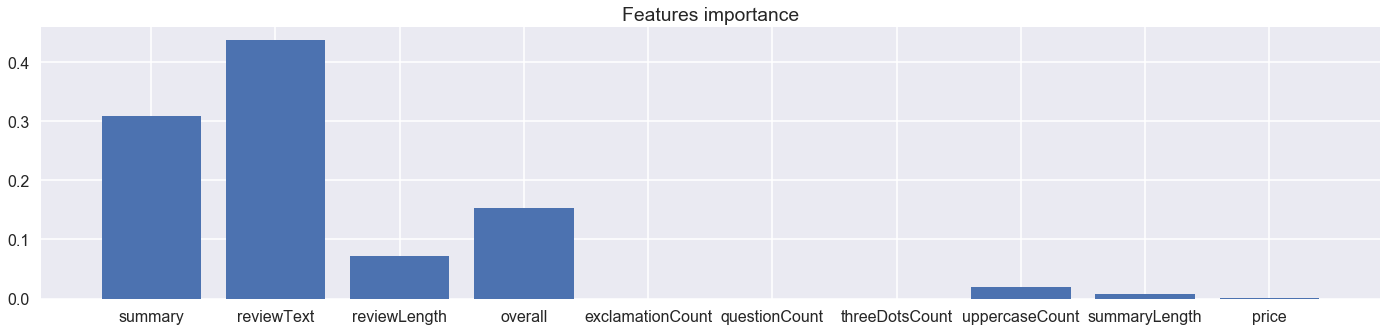

In [564]:
w2c_dim = 300
importants = []

importants.append(np.sum(clf.feature_importances_[0:w2c_dim]))
importants.append(np.sum(clf.feature_importances_[w2c_dim:w2c_dim*2]))

for i in range(w2c_dim*2, w2c_dim*2+8):
    importants.append(clf.feature_importances_[i])

plt.figure(figsize=(24, 5))


plt.bar(range(10), importants, align='center')
plt.xticks(range(10), features_name)
plt.title('Features importance')

plt.show()

However, the classifier, without taking into account the word2vec features, seems to give a great importance to the `overall score`, and also but a lesser to the `review length`.

In [385]:
helpful_video_games[helpful_video_games.helpfulCount > 100].groupby('wasHelpful').mean()[['reviewLength', 'overall']]

,reviewLength,overall
wasHelpful,,
helpful,4210.717711,4.014695
notHelpful,1181.988789,1.354260


For this kind of reviews, it seems very easy to predict the helpfulness. There is a clear frontier between the helpful and not helpful in these features. 

Interpretation : The people are more often declaring `helpful` to reviews that give good score and has a long review text. On the contrary, they give the `notHelpful` to short and negative reviews.

However the `summary`and `reviewText` played an even better role for the outcome of the classification. Unfortunately, these features are not very interpretable (unlike TF-IDF), we cannot say more.

#### Returning to 3 class classification

In [504]:
helpful_video_games2 = helpful_video_games.copy()
helpful_video_games2['wasHelpful'] = helpful_video_games.helpfulRate.map(lambda x: 'notHelpful' if x < 0.33 else 'controversial' if x < 0.66 else 'helpful')

label_encoder2 = LabelEncoder()
label_encoder2.fit_transform(helpful_video_games2['wasHelpful'])

X_train, X_test, y_train, y_test = get_X_Y_from_df(helpful_video_games2)
print("Number of reviews:", len(helpful_video_games2))


Number of reviews: 66774


In [505]:
clf = GradientBoostingClassifier(random_state=10)

model = create_pipeline(classifier=clf)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print("Train F1-score:", f1_score(y_train, y_pred, average="macro"))

y_pred = model.predict(X_test)
print("Test F1-score:", f1_score(y_test, y_pred, average="macro"))

Train F1-score: 0.546027042372
Test F1-score: 0.515419264202


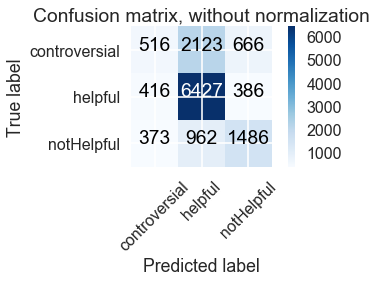

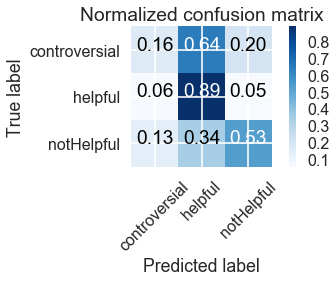

In [511]:
plots_confusion_matrices(y_test, y_pred, label_encoder2.classes_); # function from functions.py

The f1-score for the 3-class classification is quite bad. It classify well for the `helpful` example, but for `notHelpful` and `controversial` it's not very good. 

The accuracy for the `controversial` is only 16%.  
Interpretation : We can think that a review can be only useful or not useful. But subjectively, it can differ from people, one person will consider the review as useful, but for the other guy it can be completely non-sense. And this is hard for our classifier to captures this notion of controversial from our features.

##### Grid search

We tuned the parameters for our gradient boosting classifier through a grid search. You can see the details there [GridSearch for GBM](https://nbviewer.jupyter.org/github/Coac/epfl-ada/blob/master/Project/Helpful%20score%20prediction.ipynb#Grid-search-for-GBM). The elements used in training were the 1000 PC games. 

The f1-score result after the grid search were 0.59 f1-score

## Conclusion

Thanks to this deeper analysis, we were able to predict the helpful rate of the reviews. This prediction can perform very well if data is reduced to a smaller subset with high constraints (such as a high `helpfulCount`).

The main limit to our analysis is that it was only done on a small subset of reviews (*video games*). Training the classifier takes a lot of time because it is required to process a lot of text. This brings difficulties to do cross validations and grid searches. A deeper analysis which could bring new insights could be done on a larger proportion of reviews, and may bring our classifier to give better results or to be more powerful when facing to specific kind of comments.

It is also difficult to determine subjective contents of the reviews, bringing poor results for the controversial category.

Finally, the usage of other, modern methods to do the text anlysis could allow to better understand the correlation between text contents and final results. Indeed, Word2Vec algorithm is creating features which are difficult to interpret.